# Predicting HDB Resale Prices Beyond Popular Belief
Students: Sie Khai Hinn Crystaline, U2430737L & Chua Jun Xiang, U2430808E
## Practical Motivation
In Singapore, the resale market under the Housing and Development Board (HDB) plays a pivotal role in housing the nation. However, there exists a pressing need to leverage advanced analytical techniques to unravel the underlying dynamics necessary to make informed decisions.  

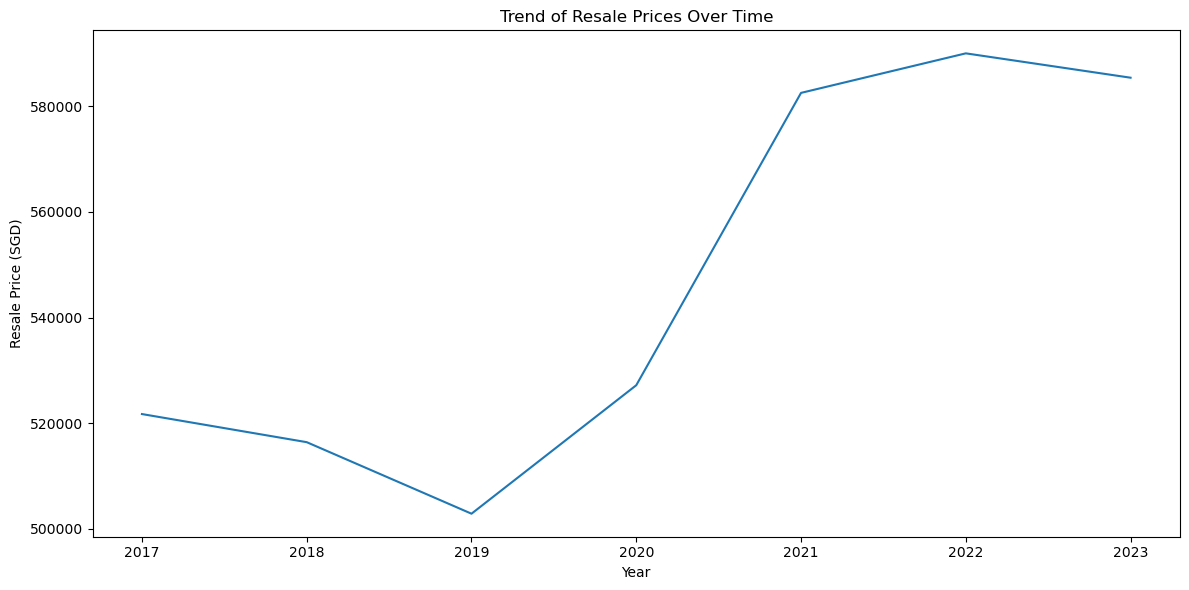

In [68]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='year', y='resale_price_adj', errorbar=None)  
plt.title("Trend of Resale Prices Over Time")
plt.xlabel("Year")
plt.ylabel("Resale Price (SGD)")
plt.tight_layout()
plt.show()

The graph depicting Trend of Resale Prices Over Time shows how the resale price changed tremendously over the years, not just due to the Covid-19 pandemic, but also due to inflation. 

In an article on [Straits Times, 2024](https://www.straitstimes.com/singapore/more-than-half-of-singaporeans-may-delay-plans-to-buy-home-due-to-inflation-fears-study), house-buying sentiment is cautious. A significant number of Singaporeans are feeling uncertain about making big financial decisions—like buying a home—because they are worried about rising prices, in other words, inflation. Demand may temporarily dip too. If many potential buyers delay their home purchases, the short-term housing demand might decrease, which could slow down resale volume or price growth—especially in the private market or higher-end HDB flats.

## Problem Statement
Therefore, we decided to leverage machine learning—not only to demystify **pricing myths** but to **empower** homeowners with accurate, data-driven insights. We hope this helps sellers price fairly and effectively, while making homes more accessible for buyers.

#### What are some of these pricing myths?

Larger floor areas tend to fetch higher resale prices.
Older flats (40+ years old) are assumed to be less desirable and cheaper.
Premium flat models (eg: Premium Apartment, DBSS, Improved) tend to fetch higher prices.
Larger flat types (5-room) are expected to have higher prices, because they offer more space.
Higher floors (19 to 21, 22 to 24) are believed to have higher prices, due to better views, privacy, less noise compared to lower floors.
The nearer the distance to the nearest MRT, the higher the resale price due to greater accessibility.

## Data Cleaning
- extracted 2017 to the first month of 2024
- accounted for Inflation that increases every year
- converted storey_range to avg_storey
- converted lease_commence_date to remaining_lease_months

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import time
from geopy.distance import geodesic
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, mean_absolute_error, silhouette_score, confusion_matrix, classification_report, roc_curve, auc

df = pd.read_csv("C:/Users/Crystaline/Downloads/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169584 entries, 0 to 169583
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                169584 non-null  object 
 1   town                 169584 non-null  object 
 2   flat_type            169584 non-null  object 
 3   block                169584 non-null  object 
 4   street_name          169584 non-null  object 
 5   storey_range         169584 non-null  object 
 6   floor_area_sqm       169584 non-null  float64
 7   flat_model           169584 non-null  object 
 8   lease_commence_date  169584 non-null  int64  
 9   remaining_lease      169584 non-null  object 
 10  resale_price         169584 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 14.2+ MB


In [89]:
df.head()

month        town flat_type block        street_name storey_range  \
0  2017-01  ANG MO KIO    2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1  2017-01  ANG MO KIO    3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2  2017-01  ANG MO KIO    3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3  2017-01  ANG MO KIO    3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4  2017-01  ANG MO KIO    3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date     remaining_lease  \
0              44        Improved                 1979  61 years 04 months   
1              67  New Generation                 1978  60 years 07 months   
2              67  New Generation                 1980  62 years 05 months   
3              68  New Generation                 1980   62 years 01 month   
4              67  New Generation                 1980  62 years 05 months   

   resale_price  
0       232,000  
1       250,000  
2       262,000  
3       265,000  
4       265,000

## Account for Inflation
resale_price_adj refers to resale_price having already accounted for Inflation as indicated by CPI

In [57]:
df["resale_price"] = df["resale_price"].astype(int)
cpi_dict = {
    2017: 85.084,
    2018: 85.457,
    2019: 85.942,
    2020: 85.794,
    2021: 87.781,
    2022: 93.163,
    2023: 97.666,
    2024: 100
}
df['year'] = pd.to_datetime(df['month']).dt.year
df['cpi'] = df['year'].map(cpi_dict)
df['resale_price_adj'] = df['resale_price'] * (cpi_dict[2024] / df['cpi'])
df.loc[df['year'] == 2024, 'resale_price_adj'] = df.loc[df['year'] == 2024, 'resale_price']
pd.set_option('display.float_format', '{:,.0f}'.format)

## Convert storey_range To avg_storey
Reason: storey_range are categorical-like strings, models cannot easily understand ranges as strings. Hence, we take the midpoint of the range, turning a vague range into a precise numeric feature. This will allow models to capture trends like: higher floor units may be more desirable.

In [59]:
def get_average_storey(s):
    try:
        parts = s.split(" TO ")
        return (int(parts[0]) + int(parts[1])) / 2
    except Exception as e:
        print(f"Error processing storey range: {s}, Error: {e}")
        return None
df["avg_storey"] = df["storey_range"].apply(get_average_storey)

## Convert lease_commence_date To remaining_lease_months
Reason: lease_commence_date does not directly reflect how much lease is left. Whereas, remaining lease directly affects valuation and demand. Numerical values all expressed in months, will also provide more predictive power.

In [60]:
def lease_to_months(lease_str):
    try:
        years, months = 0, 0
        if 'years' in lease_str:
            years = int(lease_str.split('years')[0].strip())
        if 'months' in lease_str:
            months = int(lease_str.split('years')[1].split('months')[0].strip())
        return years * 12 + months
    except:
        return None
df['remaining_lease_months'] = df['remaining_lease'].apply(lease_to_months)

## Summary of Data Cleaning

In [5]:
for col in df.columns:
    print(f"📌 Column: {col}")
    print(df[col].unique())
    print("-" * 80)
    print("\n")

📌 Column: month
['2017-01' '2017-02' '2017-03' '2017-04' '2017-05' '2017-06' '2017-07'
 '2017-08' '2017-09' '2017-10' '2017-11' '2017-12' '2018-01' '2018-02'
 '2018-03' '2018-04' '2018-05' '2018-06' '2018-07' '2018-08' '2018-09'
 '2018-10' '2018-11' '2018-12' '2019-01' '2019-02' '2019-03' '2019-04'
 '2019-05' '2019-06' '2019-07' '2019-08' '2019-09' '2019-10' '2019-11'
 '2019-12' '2020-01' '2020-02' '2020-03' '2020-04' '2020-05' '2020-06'
 '2020-07' '2020-08' '2020-09' '2020-10' '2020-11' '2020-12' '2021-01'
 '2021-02' '2021-03' '2021-04' '2021-05' '2021-06' '2021-11' '2021-07'
 '2021-08' '2021-09' '2021-10' '2021-12' '2022-01' '2022-02' '2022-03'
 '2022-04' '2022-05' '2022-06' '2022-07' '2022-08' '2022-09' '2022-10'
 '2022-11' '2022-12' '2023-01' '2023-02' '2023-03' '2023-04' '2023-05'
 '2023-06' '2023-07' '2023-08' '2023-09' '2023-10' '2023-11' '2023-12'
 '2024-01']
--------------------------------------------------------------------------------


📌 Column: town
['ANG MO KIO' 'BEDOK' 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169584 entries, 0 to 169583
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   month                   169584 non-null  object 
 1   town                    169584 non-null  object 
 2   flat_type               169584 non-null  object 
 3   block                   169584 non-null  object 
 4   street_name             169584 non-null  object 
 5   storey_range            169584 non-null  object 
 6   floor_area_sqm          169584 non-null  float64
 7   flat_model              169584 non-null  object 
 8   lease_commence_date     169584 non-null  int64  
 9   remaining_lease         169584 non-null  object 
 10  resale_price            169584 non-null  int32  
 11  year                    169584 non-null  int32  
 12  cpi                     169584 non-null  float64
 13  resale_price_adj        169584 non-null  float64
 14  avg_storey          

In [7]:
df.describe()

floor_area_sqm  lease_commence_date  resale_price    year     cpi  \
count         169,584              169,584       169,584 169,584 169,584   
mean               97                1,996       491,214   2,020      89   
std                24                   14       169,917       2       5   
min                31                1,966       140,000   2,017      85   
25%                82                1,985       365,000   2,019      86   
50%                93                1,996       460,000   2,020      86   
75%               112                2,009       585,000   2,022      93   
max               249                2,022     1,500,000   2,024     100   

       resale_price_adj  avg_storey  remaining_lease_months  
count           169,584     169,584                 169,584  
mean            550,367           9                     896  
std             184,304           6                     166  
min             153,585           2                     504  
25%             415,808           5                     761  
50%             518,180           8                     895  
75%             645,988          11                   1,056  
max           1,549,310          50                   1,173

# EDA Numeric Data
The numerical variables for EDA are: resale_price_adj, floor_area_sqm, remaining_lease_months.

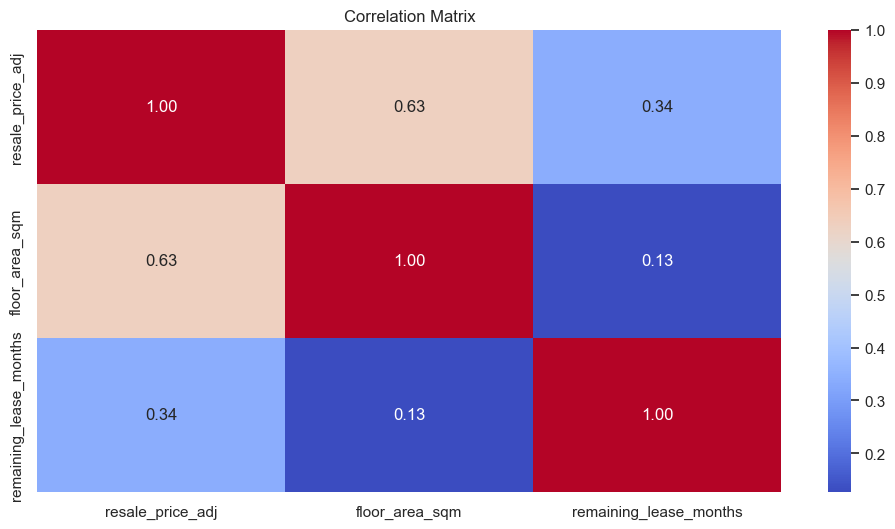

In [108]:
df_numeric = df[['resale_price_adj', 'floor_area_sqm', 'remaining_lease_months']]
plt.figure(figsize=(12, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

Insights: Positive Correlations    
floor_area_sqm and resale_price (0.60): Larger floor areas tend to have higher resale prices.  
remaining_lease_months and resale_price (0.33): Newer properties generally have higher resale prices.

## EDA: floor_area_sqm Uni-Variate

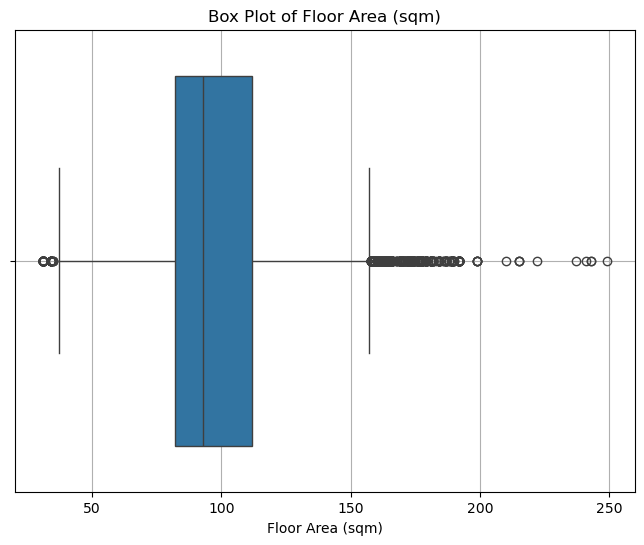

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x=df['floor_area_sqm'])

plt.title('Box Plot of Floor Area (sqm)')
plt.xlabel('Floor Area (sqm)')
plt.grid(True)
plt.show()

## EDA: floor_area_sqm Bi-Variate and Multi-Variate
The Histograms are Uni-Variate  
Dual Y-Axis Histogram is the multi-variate eda on floor_area_sqm

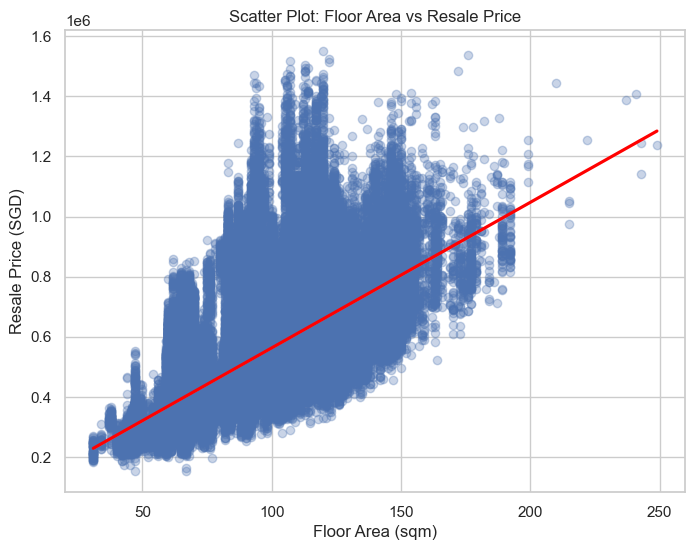

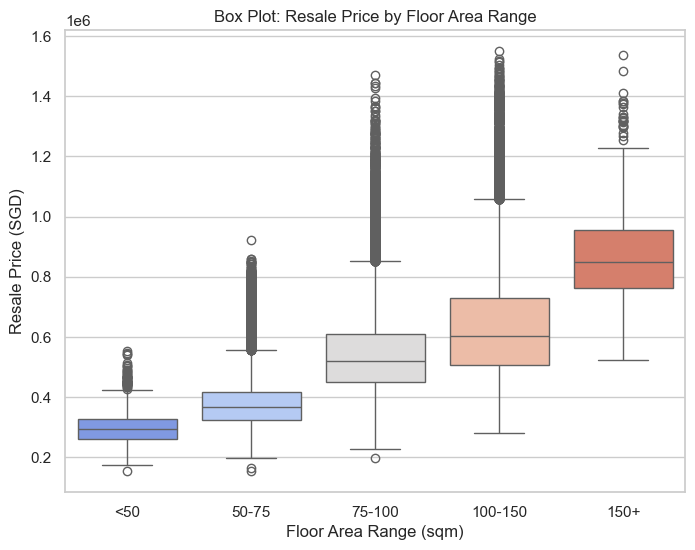

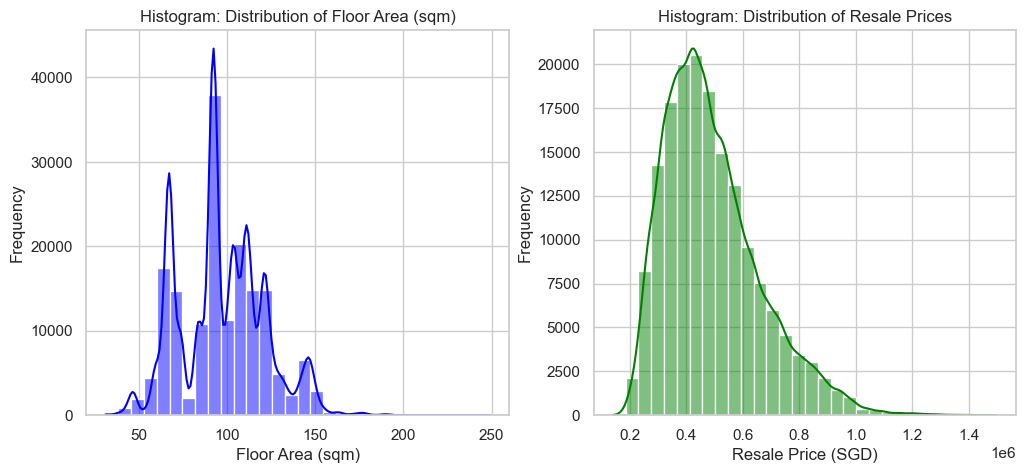

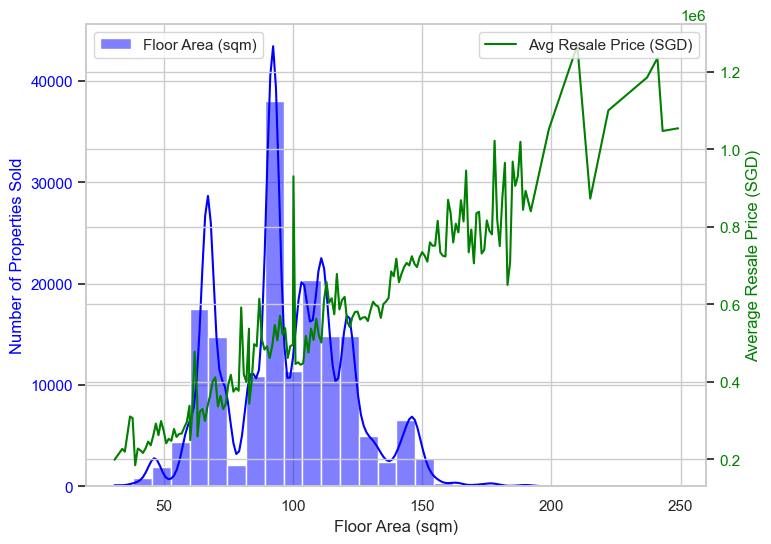

In [111]:
sns.set_style("whitegrid")

# Scatter Plot
plt.figure(figsize=(8, 6))
sns.regplot(x=df["floor_area_sqm"], y=df["resale_price_adj"], scatter_kws={"alpha": 0.3}, line_kws={"color": "red"})
plt.title("Scatter Plot: Floor Area vs Resale Price")
plt.xlabel("Floor Area (sqm)")
plt.ylabel("Resale Price (SGD)")
plt.show()

# Box Plot
df["floor_area_range"] = pd.cut(df["floor_area_sqm"], bins=[0, 50, 75, 100, 150, 200], labels=["<50", "50-75", "75-100", "100-150", "150+"])
plt.figure(figsize=(8, 6))
sns.boxplot(x="floor_area_range", y="resale_price_adj", data=df, hue="floor_area_range", palette="coolwarm", legend=False)
plt.title("Box Plot: Resale Price by Floor Area Range")
plt.xlabel("Floor Area Range (sqm)")
plt.ylabel("Resale Price (SGD)")
plt.show()

# Histograms
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df["floor_area_sqm"], bins=30, kde=True, ax=ax[0], color="blue")
ax[0].set_title("Histogram: Distribution of Floor Area (sqm)")
ax[0].set_xlabel("Floor Area (sqm)")
ax[0].set_ylabel("Frequency")
sns.histplot(df["resale_price"], bins=30, kde=True, ax=ax[1], color="green")
ax[1].set_title("Histogram: Distribution of Resale Prices")
ax[1].set_xlabel("Resale Price (SGD)")
ax[1].set_ylabel("Frequency")
plt.show()

# Floor Area stats
floor_min = df["floor_area_sqm"].min()
floor_max = df["floor_area_sqm"].max()
floor_mode = df["floor_area_sqm"].mode()[0]
floor_mode_count = df["floor_area_sqm"].value_counts().max()

print("🏠 Floor Area (sqm):")
print(f" - Min: {floor_min}")
print(f" - Max: {floor_max}")
print(f" - Most frequent value: {floor_mode} sqm (appears {floor_mode_count} times)\n")

# Resale Price stats
price_min = df["resale_price"].min()
price_max = df["resale_price"].max()
price_mode = df["resale_price"].mode()[0]
price_mode_count = df["resale_price"].value_counts().max()

print("💰 Resale Price (SGD):")
print(f" - Min: ${price_min:,.0f}")
print(f" - Max: ${price_max:,.0f}")
print(f" - Most frequent value: ${price_mode:,.0f} (appears {price_mode_count} times)")

# Dual Y-Axis Histogram, Combining the Above
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

sns.histplot(df["floor_area_sqm"], bins=30, kde=True, color="blue", label="Floor Area (sqm)", alpha=0.5, ax=ax1)
ax1.set_xlabel("Floor Area (sqm)")
ax1.set_ylabel("Number of Properties Sold", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

sns.lineplot(x=df["floor_area_sqm"], y=df.groupby("floor_area_sqm")["resale_price"].transform("mean"), color="green", label="Avg Resale Price (SGD)", ax=ax2)
ax2.set_ylabel("Average Resale Price (SGD)", color="green")
ax2.tick_params(axis='y', labelcolor="green")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

Insights:  
The average resale price for the dual-axis histrogram = the mean resale price of all transactions with that specific size.

🟦 Volume of Sales vs. Floor Area (Blue Bars & Line)  
Most Common Floor Areas:  
The majority of resale flats fall between 80–110 sqm, with strong peaks around 90 sqm and 100 sqm — likely representing standard [*4-room*](https://www.dollarsandsense.sg/hdb-4-room-flats-singapore/#:~:text=90%20(2000%20%2DPresent)%20%E2%80%93%20100%20(1998%20%E2%80%93%202000 ) and 5-room flats.

Sharp Drop-Off:  
After 130–140 sqm, the number of units sold drops significantly. Larger flats (e.g., [*executive flats, maisonettes*](https://www.propertyguru.com.sg/property-guides/where-to-find-executive-maisonette-and-how-much-do-they-cost-28807#:~:text=executive%20maisonettes%20(or%20EMs)%20in%20Singapore%20are%20still%20highly%20sought%2Dafter%20among%20home%20buyers%20because%20of%20their%20rarity%20and%20unique%20attributes%20that%20set%20them%20apart%20from%20regular%20HDB%20flats)) are less common in the market, possibly due to limited supply or niche demand.

Very Low Sales for Very Small Units (<40 sqm):  
These are likely 1-room or studio flats, which are rarely transacted and cater to a smaller population group (e.g., singles or elderly).

🧠 Interesting Interplay  
High Preference for More Space ≠ Highest Price:  
The floor area with the most transactions (around 90–100 sqm) does not correspond with the highest average prices, suggesting [*demand-driven*](https://www.channelnewsasia.com/singapore/strong-demand-young-families-pushed-prices-4-room-hdb-flats-35-over-last-5-years-say-analysts-4082286#:~:text=Four%2Droom%20flats%20are%20still%20typically%20more%20affordable%20than%20the%20bigger%20flats%2C%20and%20appeal%20to%20younger%20families%20and%20some%20seniors%20who%20are%20looking%20to%20downsize%20to%20a%20smaller%20unit%2C%20said%20observers.%C2%A0) volume rather than value-per-unit-size.

Scarcity Commands Price:  
Even though larger flats are rare, they command higher average prices — possibly due to exclusive flat types, low supply, or niche buyer segments (e.g., multi-gen families).

## EDA: lease_commence_date -> property age Uni-Variate

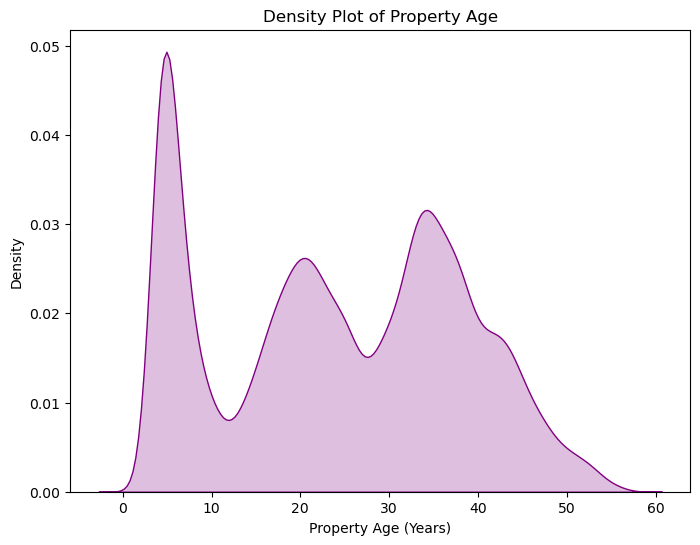

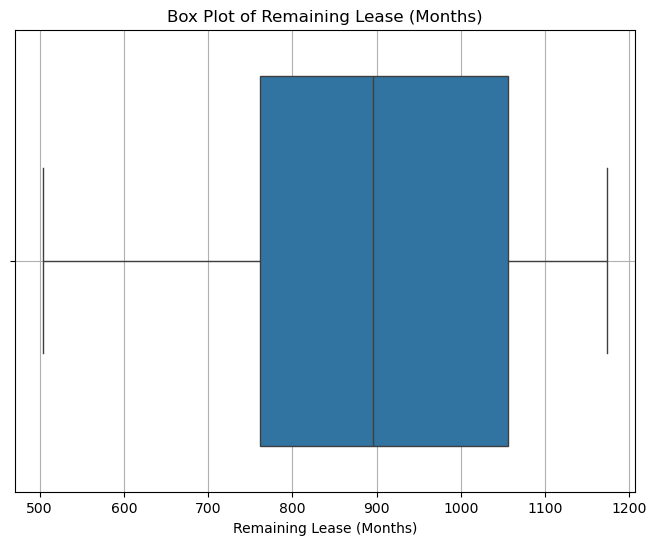

In [76]:
df["property_age"] = df['year'] - df["lease_commence_date"]

df["property_age_group"] = pd.cut(df["property_age"], bins=[0, 10, 20, 30, 40, 50, 60],
                                   labels=["0-10", "10-20", "20-30", "30-40", "40-50", "50+"])
plt.figure(figsize=(8, 6))
sns.kdeplot(df["property_age"], fill=True, color="purple")
plt.title("Density Plot of Property Age")
plt.xlabel("Property Age (Years)")
plt.show()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x=df['remaining_lease_months'])

plt.title('Box Plot of Remaining Lease (Months)')
plt.xlabel('Remaining Lease (Months)')
plt.grid(True)
plt.show()

## EDA: Property Age, Bi-Variate

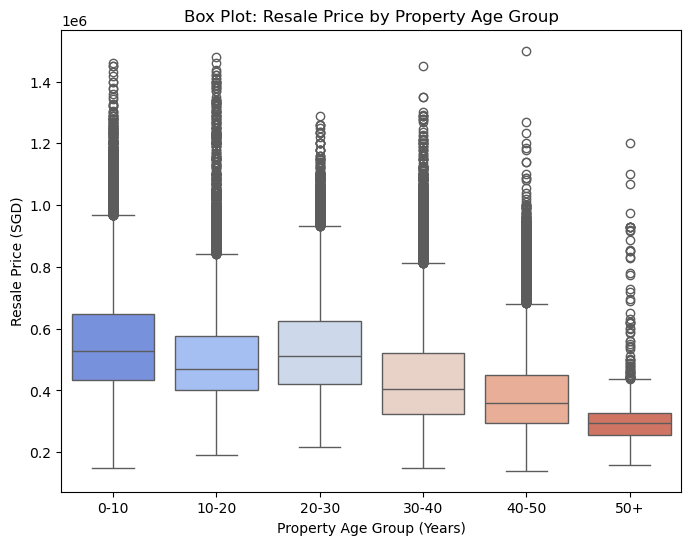

In [75]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="property_age_group", y="resale_price", hue="property_age_group", data=df, palette="coolwarm", legend=False)
plt.title("Box Plot: Resale Price by Property Age Group")
plt.xlabel("Property Age Group (Years)")
plt.ylabel("Resale Price (SGD)")
plt.show()

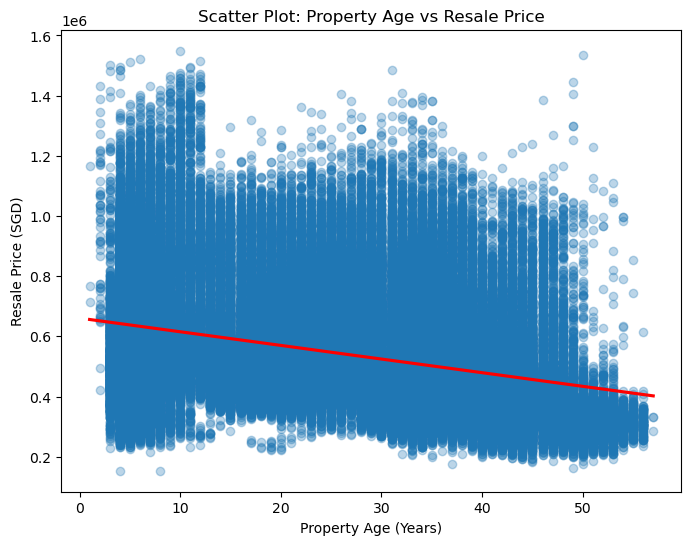

In [12]:
plt.figure(figsize=(8, 6))
sns.regplot(x=df["property_age"], y=df["resale_price_adj"], scatter_kws={"alpha": 0.3}, line_kws={"color": "red"})
plt.title("Scatter Plot: Property Age vs Resale Price")
plt.xlabel("Property Age (Years)")
plt.ylabel("Resale Price (SGD)")
plt.show()

Insights:
1. Resale Prices Decline with Property Age (RED LINE)
   - The red line (right y-axis) shows that **average resale prices tend to decrease as property age increases**.  
   - Newer properties (0-10 years old) have significantly higher prices, while older properties (40+ years) have lower resale values.  

2. Number of Properties Sold is High for Both New & Old Properties  (BLUE BARS)
   - The blue bars (left y-axis) show **high transaction volumes for very new properties (0-10 years)** and **older properties (30-50 years)**.  
   - This suggests that **new properties are in demand**, and **many old flats are being resold, possibly due to lease expiry concerns**.  

3. Volatility in Price Trends for Younger Properties  
   - The resale price trend (red line) fluctuates heavily in the **0-20 year range**, which could indicate **variability in demand for newer properties** due to factors like location, condition, or government policies.  

4. Steady Decline in Prices for Older Properties
   - Beyond 30 years, prices show a steady downward trend, likely due to factors like **lease decay (for leasehold properties)** and **aging infrastructure**. Actually, our EDA seems to support lease decay, but upon further analysis through linear and non-linear regression, the factor of remaining lease turns out not to be as strong as we thought.

Conclusion:  
- Buyers may prefer newer properties for **higher value retention**, while older properties continue to be transacted despite declining prices.  
- The **spike in transactions for old properties** suggests many homeowners may be selling before lease decay significantly impacts value.  

## EDA: Resale Price, Uni-Variate

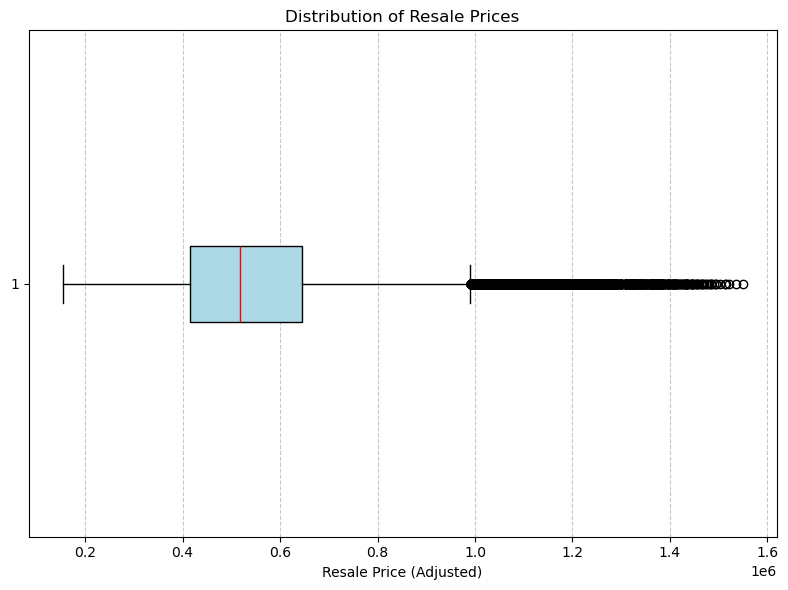

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.boxplot(df['resale_price_adj'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            medianprops=dict(color='red'))

plt.xlabel("Resale Price (Adjusted)")
plt.title("Distribution of Resale Prices")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## EDA: Resale Price, Bi-Variate

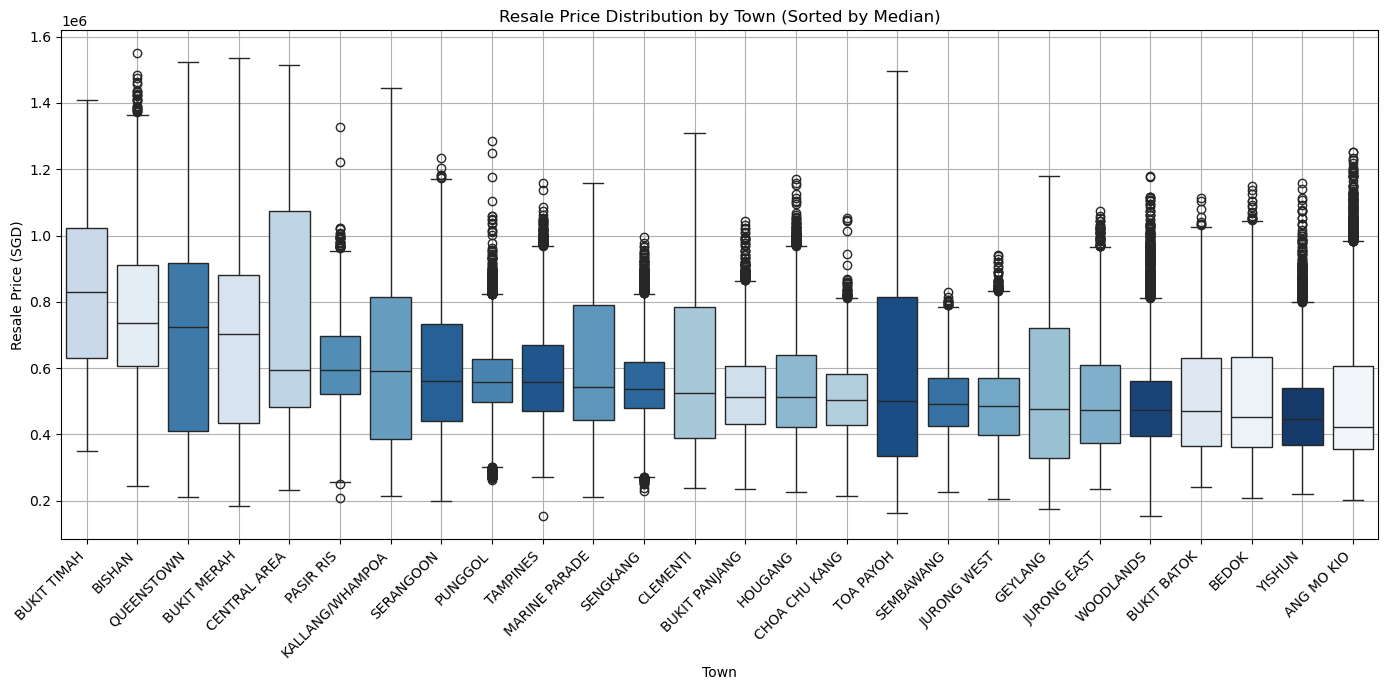

Top 5 Most Expensive Towns (Median Resale Price):
town
BUKIT TIMAH    829,748
BISHAN         737,206
QUEENSTOWN     724,537
BUKIT MERAH    703,069
CENTRAL AREA   595,091
Name: resale_price_adj, dtype: float64

Top 5 Most Affordable Towns (Median Resale Price):
town
WOODLANDS     473,915
BUKIT BATOK   470,993
BEDOK         452,246
YISHUN        445,426
ANG MO KIO    423,111
Name: resale_price_adj, dtype: float64

Towns with the Largest Resale Price Range:
town
BUKIT MERAH    1,352,850
TOA PAYOH      1,331,709
QUEENSTOWN     1,309,927
BISHAN         1,304,538
CENTRAL AREA   1,282,252
Name: resale_price_adj, dtype: float64


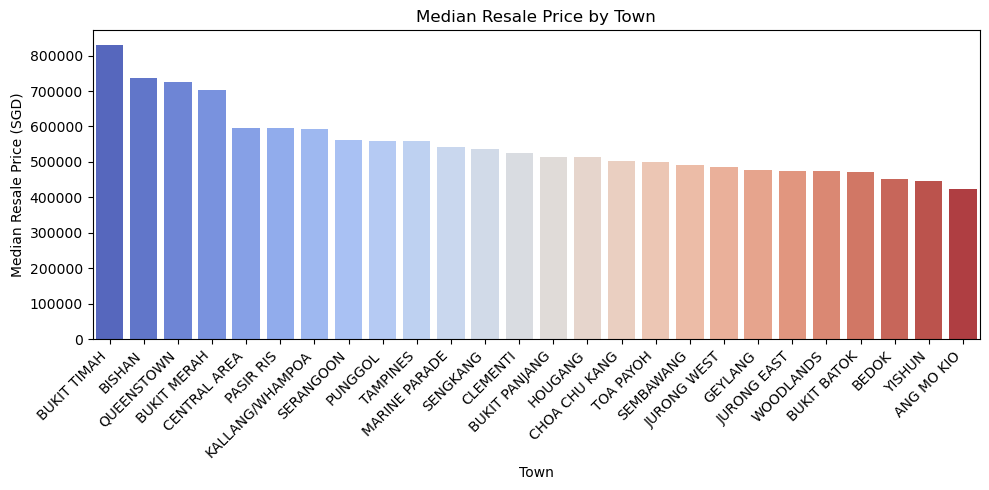

In [13]:
df["town"] = df["town"].astype(str).str.upper()
median_prices = df.groupby("town")["resale_price_adj"].median().sort_values(ascending=False)

# Boxplot
plt.figure(figsize=(14, 7))
sns.boxplot(
    data=df,
    x="town",
    y="resale_price_adj",
    order=median_prices.index,
    hue="town",                 
    palette="Blues",
    legend=False              
)
plt.xticks(rotation=45, ha='right') 
plt.title("Resale Price Distribution by Town (Sorted by Median)")
plt.xlabel("Town")
plt.ylabel("Resale Price (SGD)")
plt.grid(True)
plt.tight_layout()
plt.show()

highest_towns = median_prices.head(5)
lowest_towns = median_prices.tail(5)

print("Top 5 Most Expensive Towns (Median Resale Price):")
print(highest_towns)

print("\nTop 5 Most Affordable Towns (Median Resale Price):")
print(lowest_towns)

price_range = df.groupby("town")["resale_price_adj"].agg(lambda x: x.max() - x.min()).sort_values(ascending=False)

print("\nTowns with the Largest Resale Price Range:")
print(price_range.head(5))

median_prices_df = median_prices.reset_index()
median_prices_df.columns = ['town', 'median_resale_price']

plt.figure(figsize=(10, 5))
sns.barplot(
    data=median_prices_df,
    x="town",
    y="median_resale_price",
    hue="town",               
    palette="coolwarm",
    legend=False          
)
plt.xticks(rotation=45, ha='right')
plt.title("Median Resale Price by Town")
plt.xlabel("Town")
plt.ylabel("Median Resale Price (SGD)")
plt.tight_layout()
plt.show()

Insights from the Box Plot of Resale Prices by Town:  
1. Price Variability Across Towns  
    - Some towns (e.g., [Bukit Timah, Central Area, Queenstown](https://www.channelnewsasia.com/singapore/mature-estates-hdb-flats-classified-cna-explains-3581846#:~:text=mature%20estates%20had%20limited%20land%20but%20high%20demand.)) have much higher median resale prices compared to others. These areas likely contain [premium properties](https://www.edgeprop.sg/property-news/bukit-timah-exclusive-enclave#:~:text=Bukit%20Timah%20contains%20a%20collection%20of%20luxurious%20condominiums%2C%20cluster%20homes%2C%20and%20landed%20houses.) or more desirable housing.  

2. Presence of Outliers  
    - Almost all towns have resale price outliers, particularly on the higher end. This suggests that while most properties fall within a typical range, there are some high-value transactions.  

3. Towns with Lower Median Prices  
    - Some towns (e.g., Bukit Panjang, Choa Chu Kang, Woodlands, Yishun) have relatively lower median prices. These areas might offer more affordable housing options.  

4. Wider Price Range in Certain Towns  
    - The Central Area and Bukit Timah have a very large range of resale prices. This suggests that these locations may have a mix of high-end and mid-range properties.  

5. Towns with More Stable Pricing  
    - Locations like [Sengkang, Punggol](https://cnalifestyle.channelnewsasia.com/singapore/focus-what-pushing-hdb-resale-prices-higher-314021#:~:text=For%20now%2C%20high,is%20S%24801%2C444.), and Pasir Ris show a narrower price range, meaning resale prices are more stable in these areas.  

Potential Conclusions  
- Affluent areas (e.g., Bukit Timah, Queenstown, Central Area) have high resale prices due to demand and exclusivity.  
- Some towns offer affordable housing options (e.g., Woodlands, Bukit Panjang, Choa Chu Kang).  
- High-price outliers may indicate luxury developments or recently renovated properties in some areas.

# EDA : Time and Resale Price

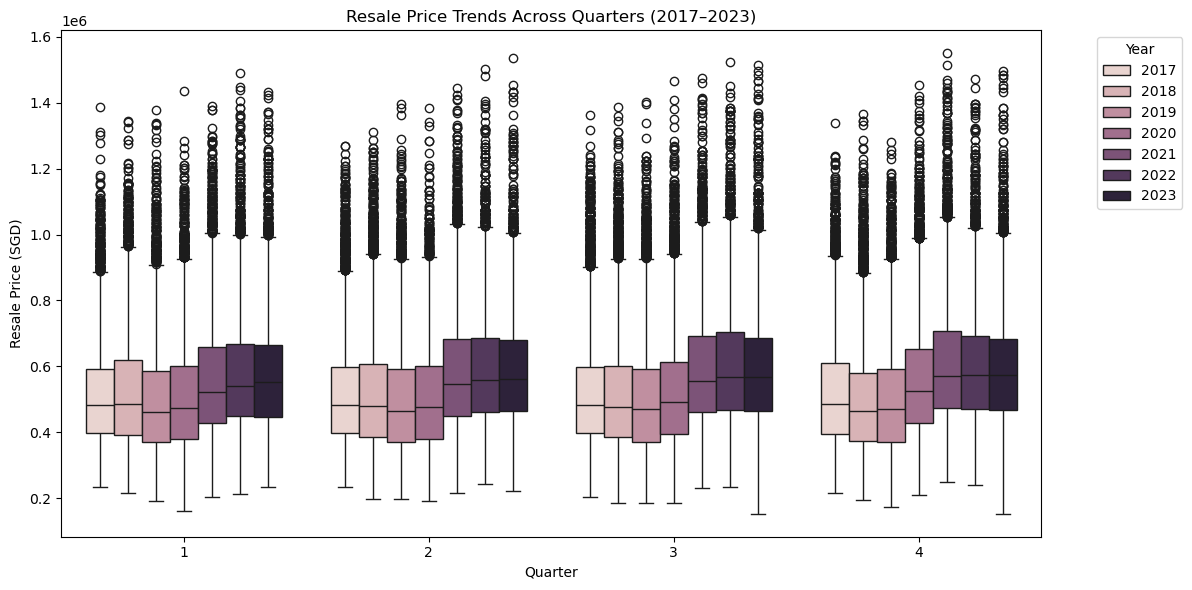

In [17]:
# Quarterly
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df['month'] = pd.to_datetime(df['month'], errors='coerce')
df['Year'] = df['month'].dt.year
df['Quarter'] = df['month'].dt.quarter
df_filtered = df[df['Year'].between(2017, 2023)]
df_filtered = df_filtered.dropna(subset=['resale_price_adj', 'Year', 'Quarter'])
plt.figure(figsize=(12, 6))
plot = sns.boxplot(x='Quarter', y='resale_price_adj', hue='Year', data=df_filtered)
handles, labels = plot.get_legend_handles_labels()
if handles:
    plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    print("Warning: No legend entries found.")

plt.title("Resale Price Trends Across Quarters (2017–2023)")
plt.xlabel("Quarter")
plt.ylabel("Resale Price (SGD)")
plt.tight_layout()
plt.show()

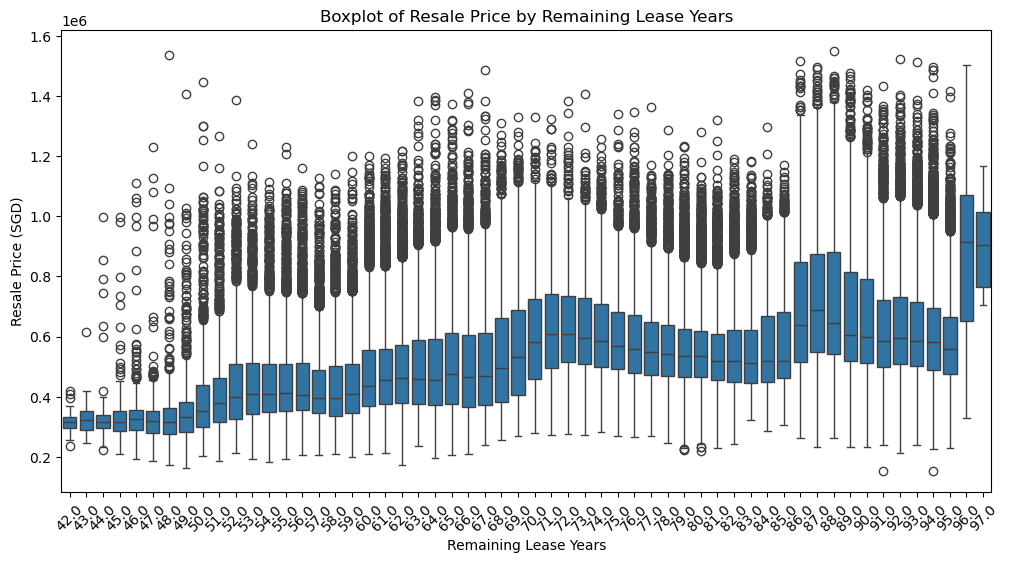

In [18]:
# Boxplot:`remaining_lease_years`
df['remaining_lease_years'] = df['remaining_lease'].str.extract(r'(\d+)\s+years').astype(float)

plt.figure(figsize=(12, 6))
sns.boxplot(x='remaining_lease_years', y='resale_price_adj', data=df)
plt.title("Boxplot of Resale Price by Remaining Lease Years")
plt.xlabel("Remaining Lease Years")
plt.ylabel("Resale Price (SGD)")
plt.xticks(rotation=45)
plt.show()

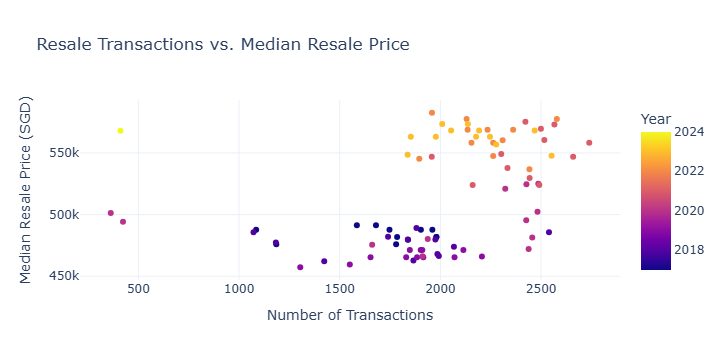

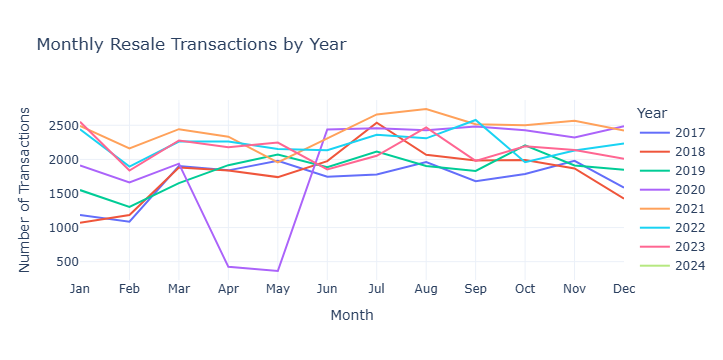

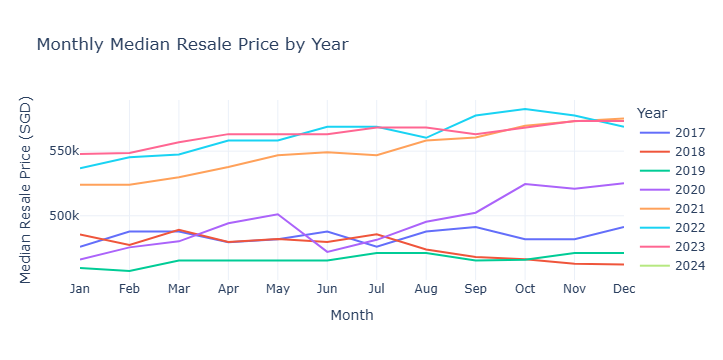

In [20]:
df['Month'] = df['month'].dt.month
monthly_data = df.groupby(["Year", "Month"]).agg(
    resale_transactions=("resale_price_adj", "count"),
    median_resale_price=("resale_price_adj", "median")
).reset_index()
monthly_data["month_name"] = monthly_data["Month"].apply(lambda x: pd.to_datetime(str(x), format='%m').strftime('%b'))

# scatter plot 
df_scatter = px.scatter(
    monthly_data, x="resale_transactions", y="median_resale_price", color="Year",
    title="Resale Transactions vs. Median Resale Price",
    labels={"resale_transactions": "Number of Transactions", "median_resale_price": "Median Resale Price (SGD)", "Year": "Year"},
    template="plotly_white"
)

# separate line plots
fig_transactions = px.line(
    monthly_data, x="month_name", y="resale_transactions", color="Year",
    title="Monthly Resale Transactions by Year",
    labels={"resale_transactions": "Number of Transactions", "month_name": "Month", "Year": "Year"},
    template="plotly_white"
)

fig_price = px.line(
    monthly_data, x="month_name", y="median_resale_price", color="Year",
    title="Monthly Median Resale Price by Year",
    labels={"median_resale_price": "Median Resale Price (SGD)", "month_name": "Month", "Year": "Year"},
    template="plotly_white"
)

df_scatter.show()
fig_transactions.show()
fig_price.show()

Insights:  
 **1. Resale Transactions vs. Median Resale Price (Top Chart)**
- There is a positive correlation between the number of transactions and the median resale price, meaning as the number of transactions increases, resale prices also tend to be higher.
- Data points from earlier years (2018, 2019) tend to cluster at lower transaction counts and lower median prices.
- More recent years (2022) show higher median prices and higher transaction counts.
- The color gradient indicates that resale prices have generally increased over time, with newer years (yellow) having higher prices than older years (purple).

 **2. Monthly Resale Transactions by Year (Middle Chart)**
- The number of transactions fluctuates throughout the year, often peaking around mid-year (June - September).
- 2020 shows an unusual dip around April and May, likely due to disruptions (possibly COVID-19 lockdowns).
- Transactions tend to be lower at the beginning and end of the year.
- The years 2022 and 2023 have higher transaction counts compared to earlier years like 2017 and 2018.

 **3. Monthly Median Resale Price by Year (Bottom Chart)**
- Median resale prices have shown an increasing trend over the years.
- The years 2022 and 2023 have significantly higher median resale prices compared to earlier years.
- There is a steady increase in resale prices across all months, with minor fluctuations.
- 2020 shows a temporary dip, aligning with the transaction drop in the middle chart.

 **Overall Observations**
- Over the years, the median resale price has been steadily increasing.
- Transaction volumes show seasonal trends, often peaking in mid-year.
- The impact of external events (e.g., [COVID-19 in 2020](https://www.sciencedirect.com/science/article/pii/S0264999323003632)) is visible in transaction data but did not have a long-term negative effect on prices.
- More recent years (2022 and 2023) have seen both higher resale prices and higher transaction volumes, indicating a strong market.

# EDA Multi-Variate
## Flat Type, Storey Range, Flat Model VERSUS Resale Price

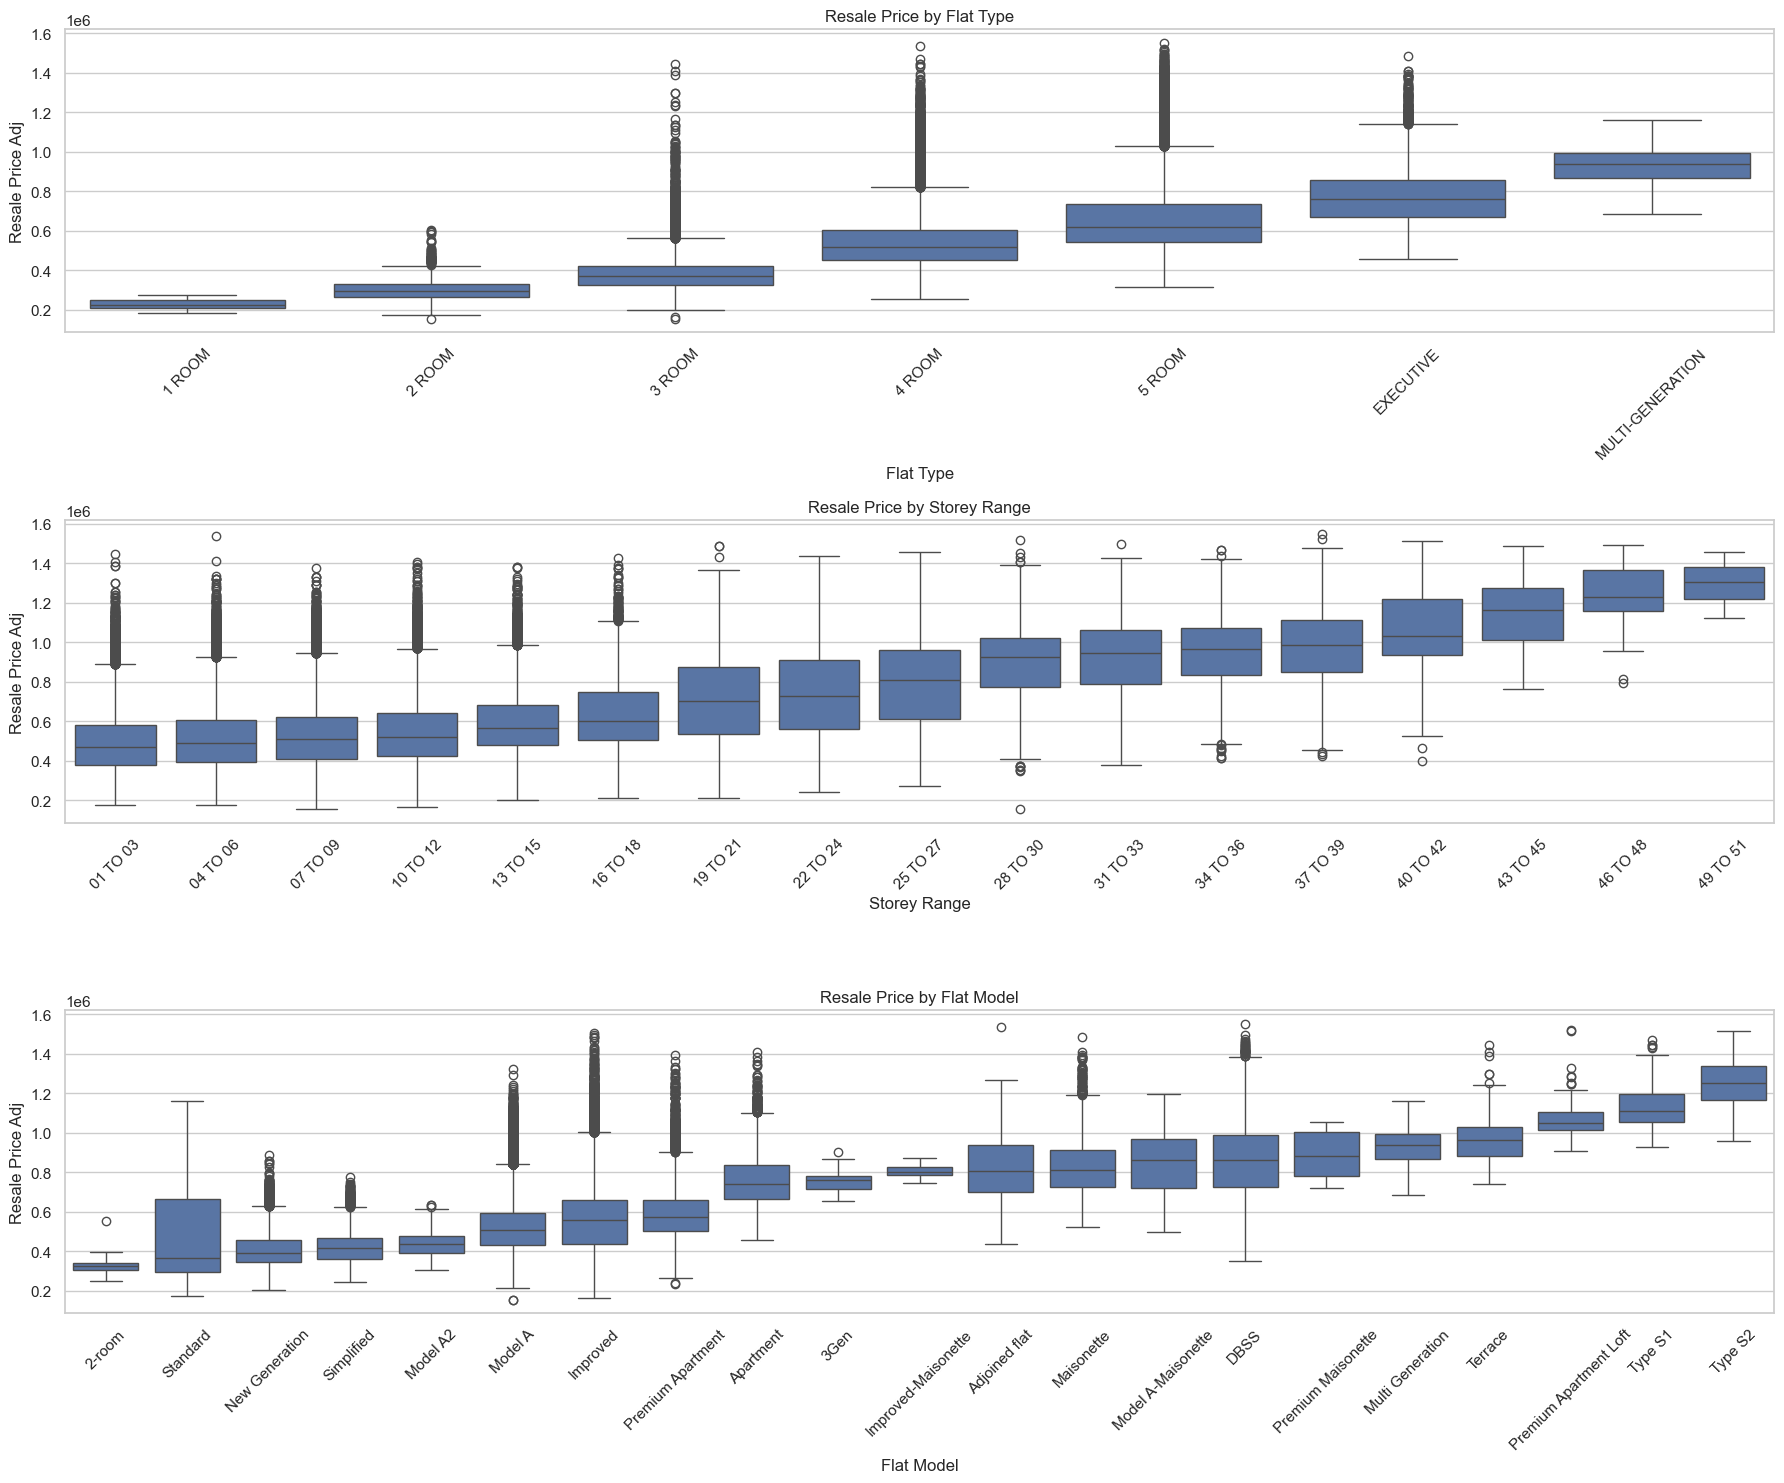

In [77]:
sns.set(style="whitegrid")

def ordered_boxplot(x, y, data, ax, title):
    order = data.groupby(x)[y].median().sort_values().index
    sns.boxplot(x=x, y=y, data=data, order=order, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x.replace('_', ' ').title())
    ax.set_ylabel(y.replace('_', ' ').title())
    ax.tick_params(axis='x', rotation=45)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 15))
ordered_boxplot(x="flat_type", y="resale_price_adj", data=df, ax=axes[0], title="Resale Price by Flat Type")
ordered_boxplot(x="storey_range", y="resale_price_adj", data=df, ax=axes[1], title="Resale Price by Storey Range")
ordered_boxplot(x="flat_model", y="resale_price_adj", data=df, ax=axes[2], title="Resale Price by Flat Model")
plt.tight_layout()
plt.show()

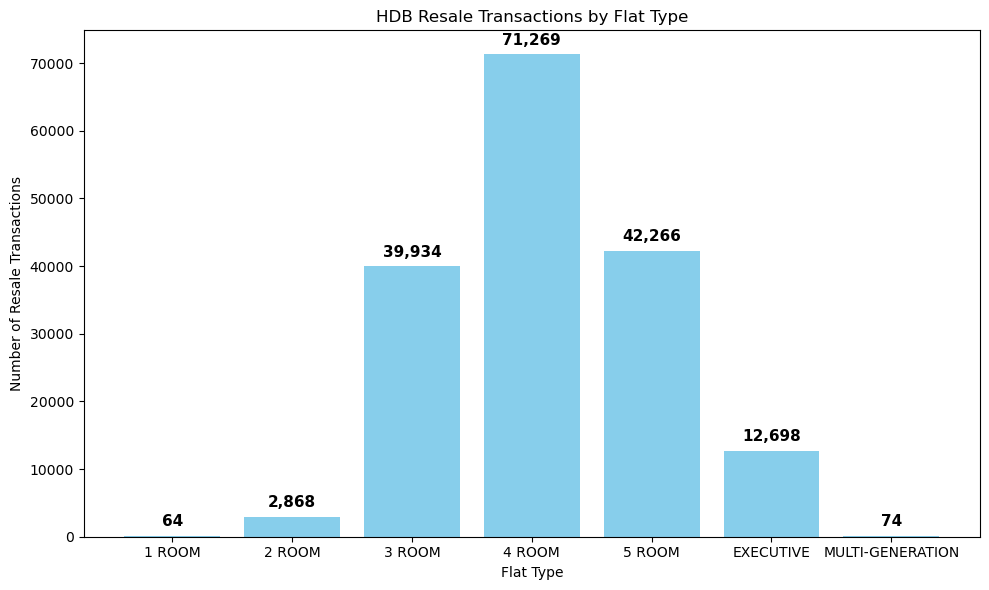

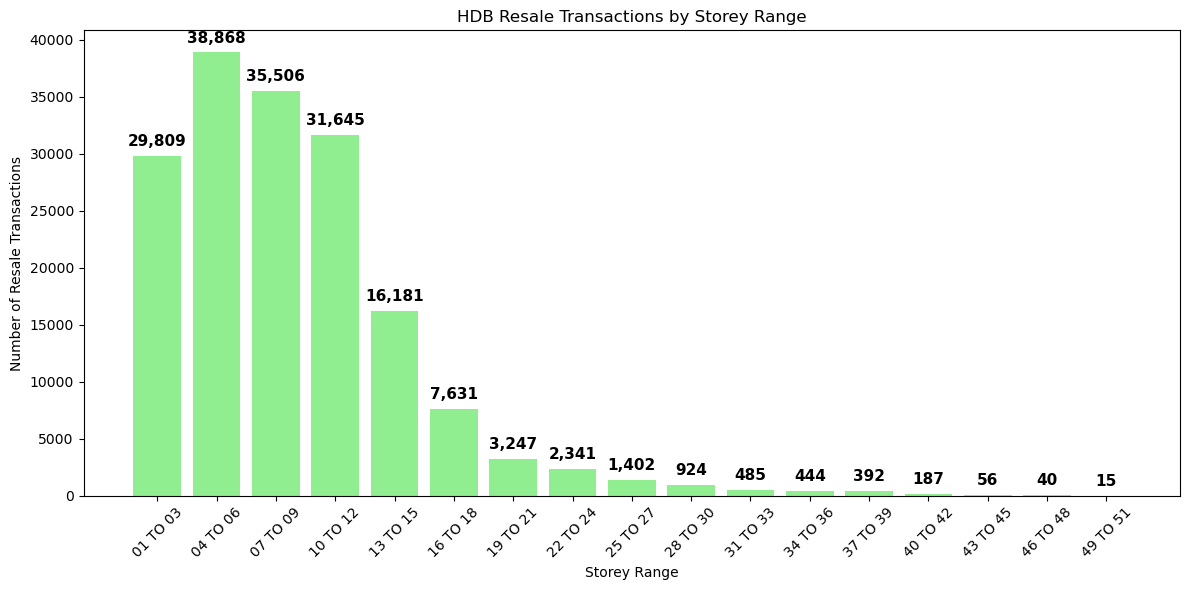

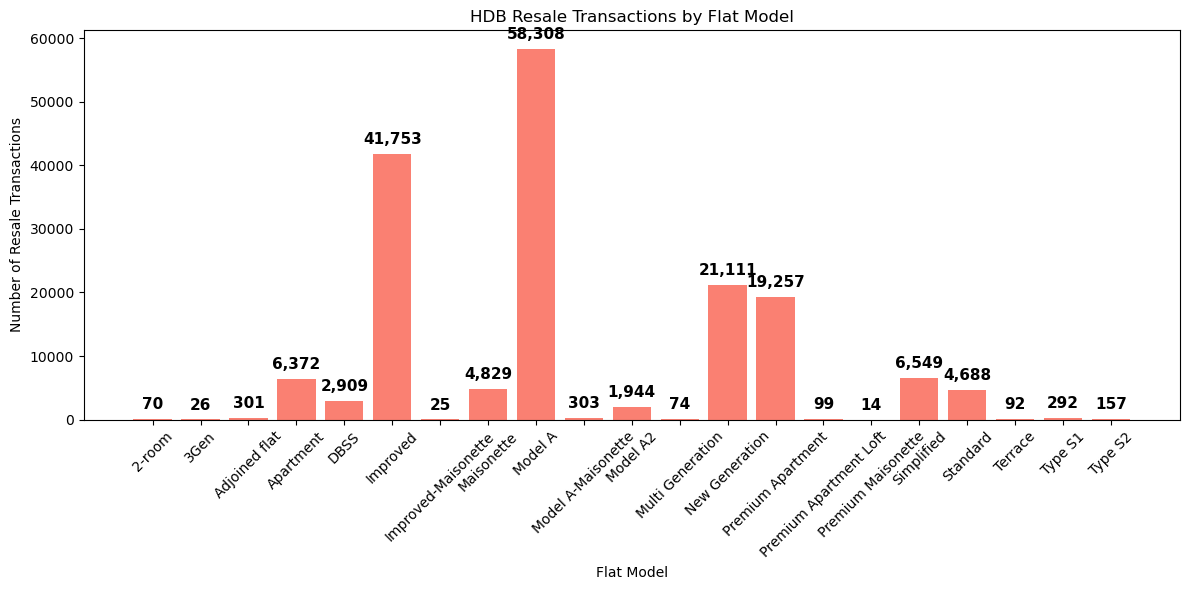

In [70]:
import matplotlib.pyplot as plt

flat_type_counts = df['flat_type'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(flat_type_counts.index, flat_type_counts.values, color='skyblue')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=11, fontweight='bold', color='black')

ax.set_xlabel("Flat Type")
ax.set_ylabel("Number of Resale Transactions")
ax.set_title("HDB Resale Transactions by Flat Type")
plt.tight_layout()
plt.show()


storey_counts = df['storey_range'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(storey_counts.index, storey_counts.values, color='lightgreen')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

ax.set_xlabel("Storey Range")
ax.set_ylabel("Number of Resale Transactions")
ax.set_title("HDB Resale Transactions by Storey Range")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

flat_model_counts = df['flat_model'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(flat_model_counts.index, flat_model_counts.values, color='salmon')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

ax.set_xlabel("Flat Model")
ax.set_ylabel("Number of Resale Transactions")
ax.set_title("HDB Resale Transactions by Flat Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Flat Type, Storey Range, Flat Model VERSUS combined Transaction Counts and Resale Price

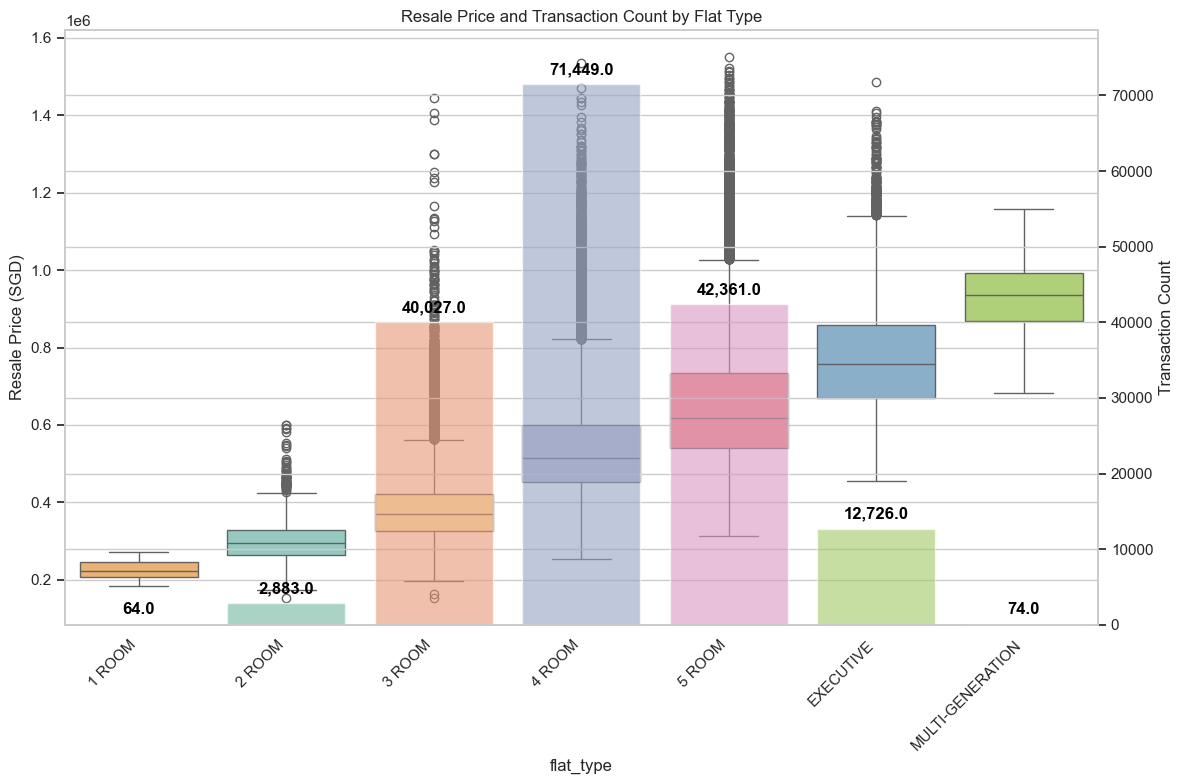

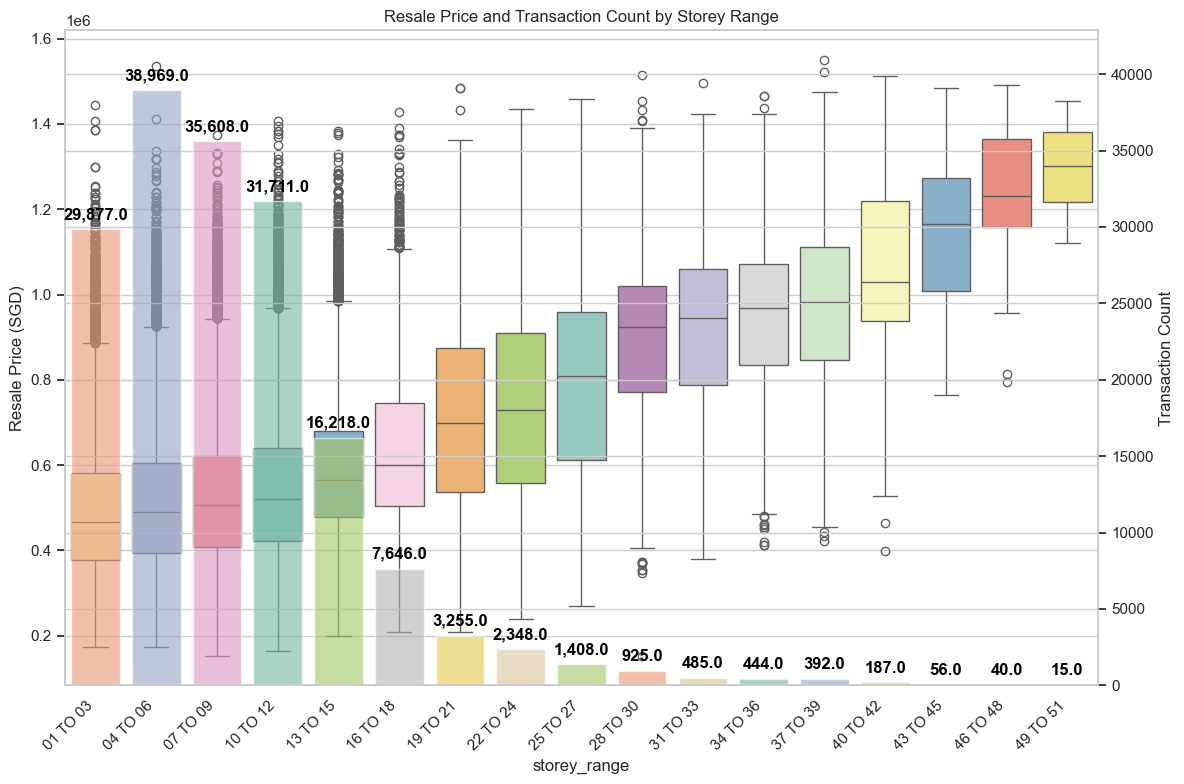

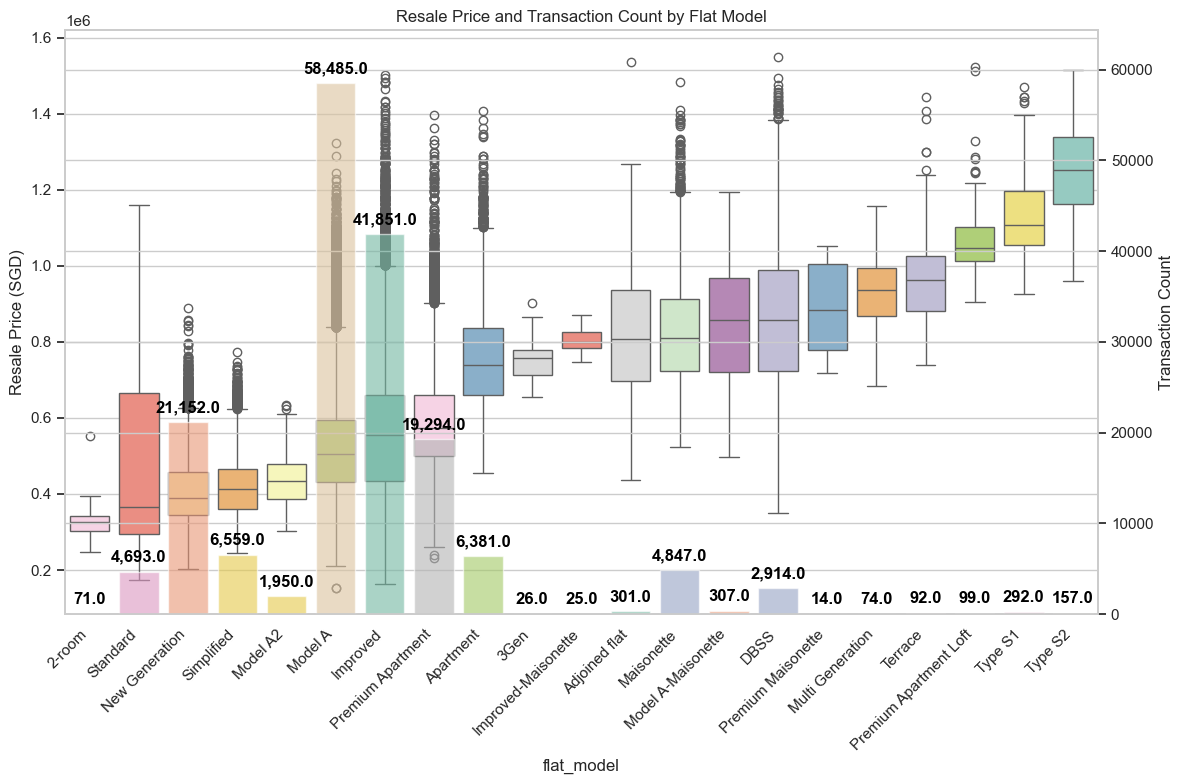

In [79]:
def combined_box_count_plot(data, x, y, title, min_bar_height_cm=1):
    import matplotlib.pyplot as plt
    import seaborn as sns
    order = data.groupby(x)[y].median().sort_values().index
    fig, ax1 = plt.subplots(figsize=(12, 8))
    sns.boxplot(x=x, y=y, hue=x, data=data, order=order, ax=ax1, palette="Set3", legend=False)
    ax1.set_ylabel('Resale Price (SGD)')
    ax1.set_title(title)
    
    ax2 = ax1.twinx()
    sns.countplot(x=x, hue=x, data=data, order=order, ax=ax2, palette="Set2", alpha=0.6, legend=False)
    ax2.set_ylabel('Transaction Count')

    for bar in ax2.patches:
        height = bar.get_height()
        ax2.annotate(f'{height:,}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 5),
                     textcoords='offset points',
                     ha='center', va='bottom',
                     fontsize=12, fontweight='bold', color='black')

    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")
    ax2.set_ylim(0, max([bar.get_height() for bar in ax2.patches]) * 1.1)
    plt.tight_layout()
    plt.show()

combined_box_count_plot(df, x='flat_type', y='resale_price_adj', title='Resale Price and Transaction Count by Flat Type')
combined_box_count_plot(df, x='storey_range', y='resale_price_adj', title='Resale Price and Transaction Count by Storey Range')
combined_box_count_plot(df, x='flat_model', y='resale_price_adj', title='Resale Price and Transaction Count by Flat Model')



🏠 1. By Flat Type  
Chart: Resale Price and Transaction Count by Flat Type

- 🔼 4-room flats dominate in both resale price and transaction count — making them the most actively traded and middle-ground choice for many buyers.  
- 🔍 5-room flats are priced slightly higher on average than 4-room flats but have fewer transactions, suggesting they may be less accessible or needed by smaller households.  
- ⚖️ Executive and Multi-Generation flats show higher resale price variance, but they are traded far less frequently, indicating they serve niche markets.  
- ✅ Insight: The 3- to 5-room flats form the core of HDB resale activity, reinforcing their importance in housing policy planning.

---

🏢 2. By Storey Range  
Chart: Resale Price and Transaction Count by Storey Range

- 🔼 Higher floors (31 and above) tend to command higher resale prices consistently — confirming that "sky view premium" is real in Singapore.  
- 📉 However, most transactions occur between the 4th and 12th storey, indicating buyers’ practical preferences (e.g. accessibility, lift access, price) outweigh premium pricing.  
- ❗ Lower storeys (1–3) and mid-range storeys (13–18) have notably lower prices, but they still capture significant transaction counts — possibly due to affordability or elderly buyers.  
- ✅ Insight: While higher floors may be more expensive, buyers still gravitate toward lower-mid floors, balancing price, accessibility, and preference.

---

🏗️ 3. By Flat Model  
Chart: Resale Price and Transaction Count by Flat Model

- 💰 Maisonettes, DBSS, and Premium Apartment Loft models have some of the highest resale prices, despite lower transaction volumes — signaling their luxury or rarity status.  
- 📦 Improved and New Generation models have high transaction counts, suggesting they’re more commonly built and traded, possibly across older estates.  
- 🧊 Old models like "Model A" and "Simplified" have lower prices and are traded much less now — indicating gradual phasing out of outdated layouts.  
- ✅ Insight: Flat model plays a huge role in pricing, beyond just size or location. Premium/rare designs draw higher prices even with low supply.

---

🌟 Big Picture Takeaways

- 💡 The HDB resale market is shaped by a complex interaction of flat type, floor level, and model — pricing isn’t determined by one factor alone.  
- 🔍 Although higher floors and premium models fetch higher prices, demand remains focused around practical, middle-tier options (4-room flats, mid-storeys, standard models).  
- 📊 These charts support your modeling conclusion that no single feature dominates resale pricing — which alignversion formatted for a slide or a report!how — I can help summarize them nicely!

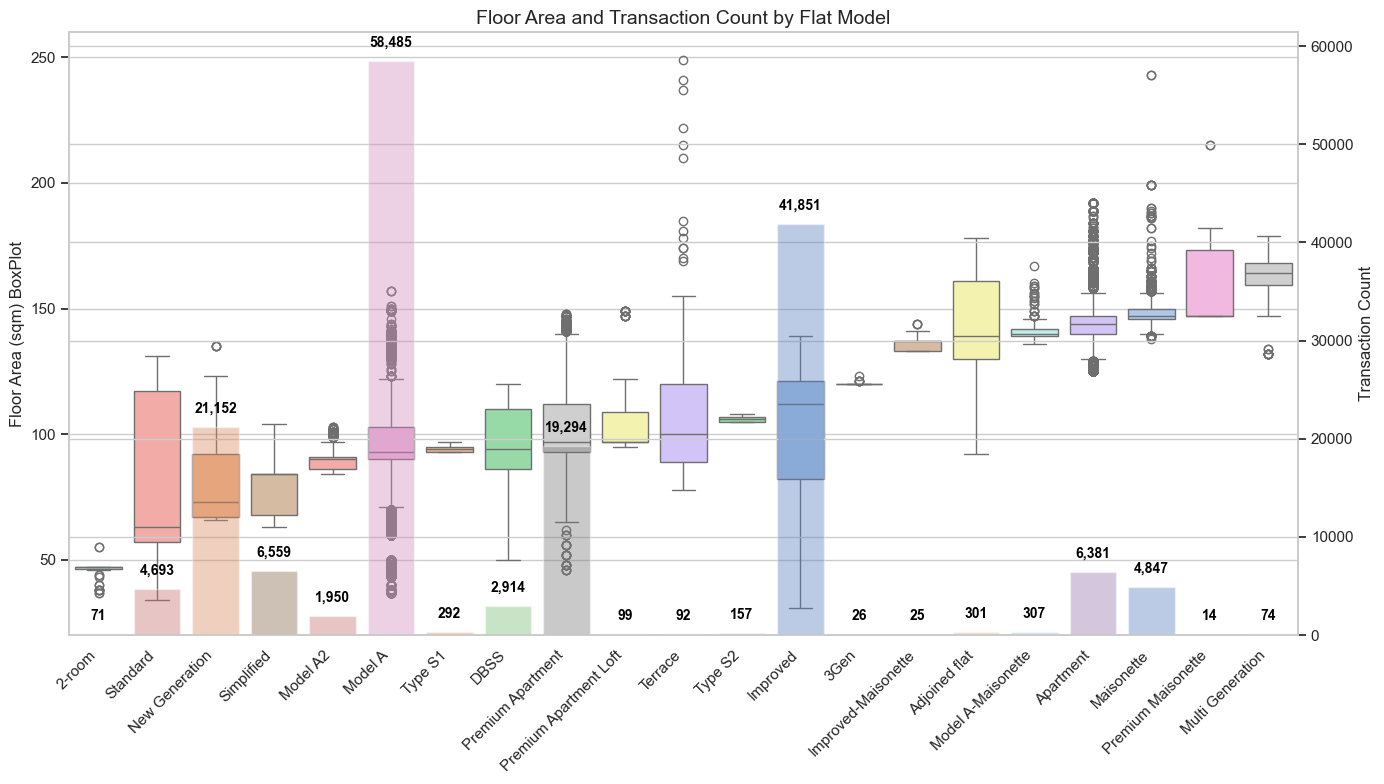

In [81]:
def var_floor_count(data, x, y, title):
    order = data.groupby(x)[y].median().sort_values().index
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Boxplot for floor area
    sns.boxplot(x=x, y=y, data=data, order=order, ax=ax1, palette="pastel", hue=x, legend=False)
    ax1.set_ylabel('Floor Area (sqm) BoxPlot', fontsize=12)
    ax1.set_xlabel('')
    ax1.set_title(title, fontsize=14)

    # Countplot on secondary axis
    ax2 = ax1.twinx()
    sns.countplot(x=x, data=data, order=order, ax=ax2, palette="muted", alpha=0.4, hue=x, legend=False)
    ax2.set_ylabel('Transaction Count', fontsize=12)

    counts = data[x].value_counts().reindex(order)
    for i, count in enumerate(counts):
        ax2.text(i, count + max(counts) * 0.02, f'{int(count):,}', ha='center', va='bottom',
                 fontsize=10, weight='bold', color='black')
    ax1.set_xticks(range(len(order)))
    ax1.set_xticklabels(order, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

var_floor_count(df, x='flat_model', y='floor_area_sqm', title='Floor Area and Transaction Count by Flat Model')

Insights:  
Model A is the most transacted flat type, followed by Improved, Premium Apartment, New Generation and Simplified. Rare/legacy types like Premium Maisonette, Maisonette, 3Gen, and Multi Generation have very low counts (< 100), possibly phased out or niche.  

Premium Apartment has a moderate-large floor area and very high transaction count, suggesting it's a popular mid-high range option.
Maisonettes offer large spaces (≥120 sqm) but are rarely transacted — possibly due to their age or limited stock.
DBSS, Terrace, and Type S1/S2 have larger areas but relatively fewer transactions — possibly because they are rare, premium-priced, or phased out.  

Model A is the sweet spot: moderate size (~100 sqm), highest count, likely reflecting standard family units in peak supply years.
Premium Apartment Loft and Terrace units stand out for size, indicating luxury-tier living within HDB constraints.








# EDA: Avg Storey, Uni-Variate

<Axes: xlabel='avg_storey', ylabel='count'>

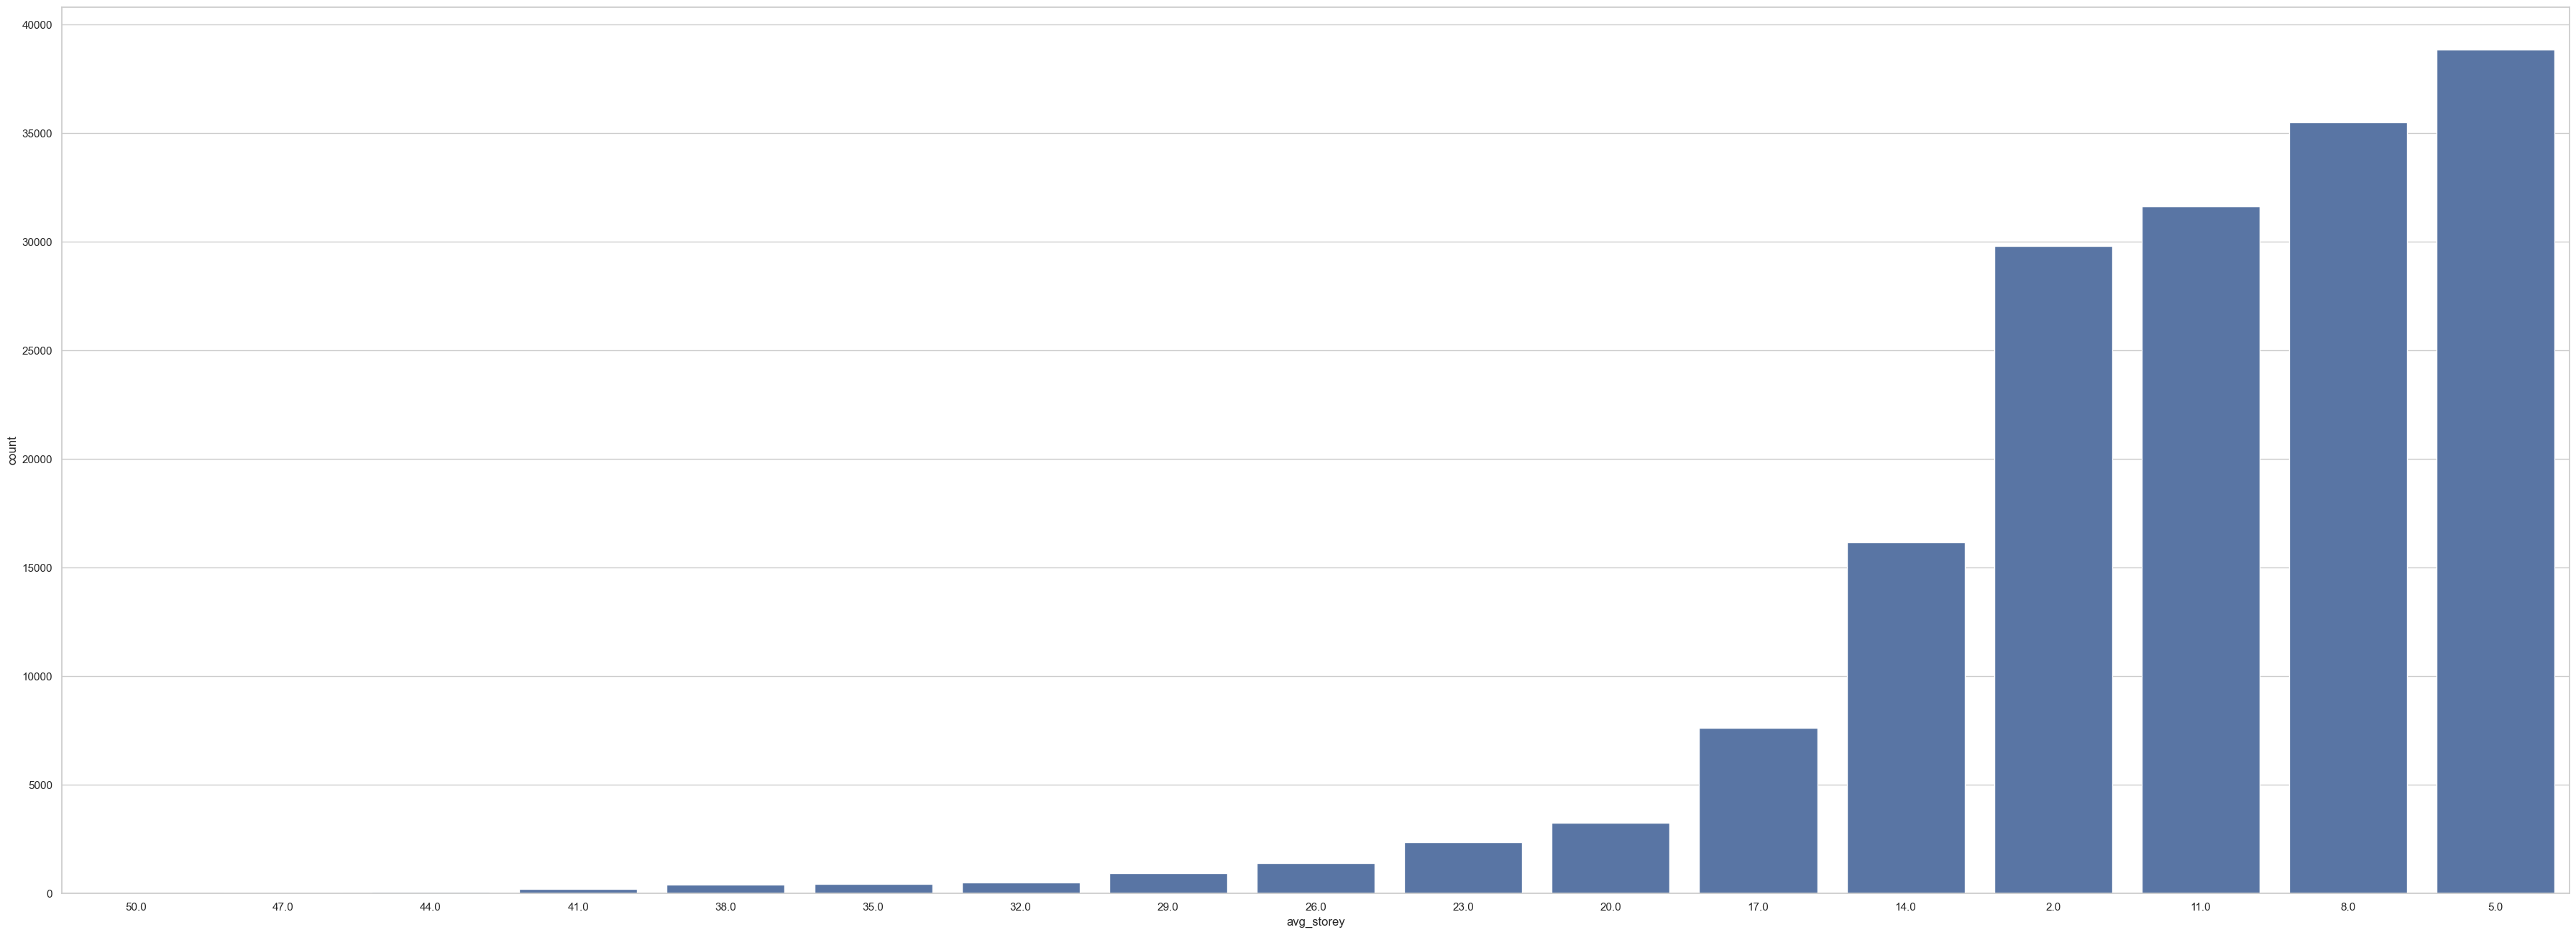

In [79]:
sns.set(style="whitegrid")
Average_Storey_order = df['avg_storey'].value_counts().sort_values(ascending=True).index
fig, axes = plt.subplots(figsize=(45, 16))
sns.countplot(data=df, x="avg_storey", order=Average_Storey_order, ax=axes)

# EDA On Flat_Type & Storey_range, Multi-Variate
According to the visualisations, it seems that even though storey tend to not affect much of the resale prices, it seems that __3 room__ flats catch higher prices at a very low floors. 

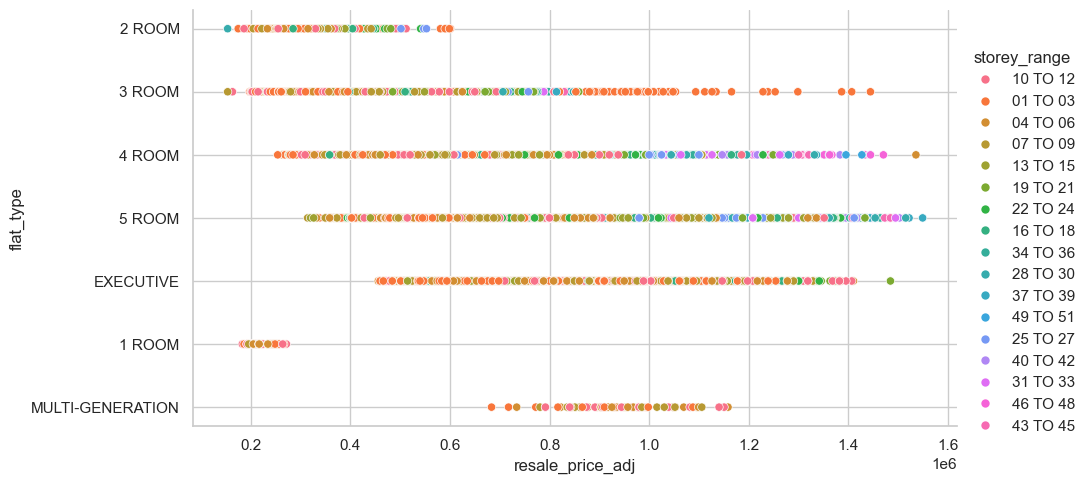

In [127]:
sns.relplot(x='resale_price_adj',y='flat_type', hue='storey_range', data=df,aspect=2 )

Insights  
Storey does not always dictate prices.  

Price Distribution by Flat Type: There is a clear progression in resale prices as the number of rooms increases. 1-room flats have the lowest prices (clustered around 200,000), while 5-room and Executive flats command higher prices.  
Multi-Generation Flats: These appear exclusively in the higher price ranges (800,000+), suggesting they're premium properties.  
Price Ranges:

1-room: Tightly clustered around 200,000  
2-room: Mostly 200,000-400,000  
3-room: Wide range from 200,000 to 1,200,000+  
4-room: Broad distribution from 300,000 to 1,600,000  
5-room: Higher concentration in 400,000-1,400,000  
Executive: Mostly 600,000-1,400,000  


Storey Impact: While there is no strong correlation, higher storey ranges (such as 43-51) tend to appear more frequently at higher price points, particularly for 4 and 5-room flats.  
Price Ceiling Variation: The maximum prices vary by flat type, with 4 and 5-room flats reaching the highest resale values (up to 1.6 million).
Outliers: There are notable outliers in each category, particularly in the 4 and 5-room types that command prices well above the typical range for their category.  
Distribution Density: 3, 4, and 5-room flats show the densest distribution, suggesting they're the most commonly traded types in this market.

# Maximum Price Housing Characteristics

In [136]:
maxpriceHouse=df.iloc[df.resale_price_adj.argmax()]
maxpriceHouse

month                                2021-12
town                                  BISHAN
flat_type                             5 ROOM
block                                   273B
street_name                     BISHAN ST 24
storey_range                        37 TO 39
floor_area_sqm                           120
flat_model                              DBSS
lease_commence_date                     2011
remaining_lease           88 years 10 months
resale_price                         1360000
year                                    2021
cpi                                       88
resale_price_adj                   1,549,310
avg_storey                                38
remaining_lease_months                  1066
floor_area_range                     100-150
property_age                              14
property_age_group                     10-20
latitude                                   1
longitude                                104
Name: 90829, dtype: object

# Clustering of Storey
This is something new we learnt.  
According to the visualisation, it shows that storey do play a small range in determining the price, however it seems that other factors play a part as well. For instance, __Central Area__ seems to provide higher resales price as compared to __Seng Kang__ irregardless of the storey the HDB is at. 

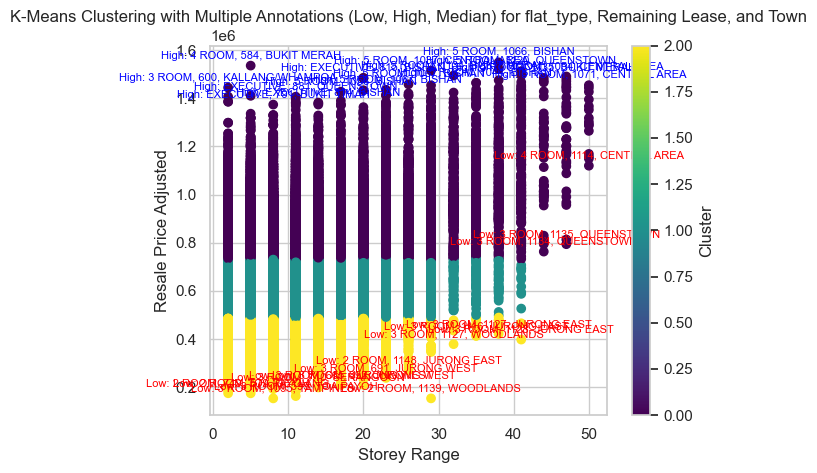

In [146]:
from sklearn.cluster import KMeans
X = df[['avg_storey', 'resale_price_adj']]
df['avg_storey'] = df['avg_storey'].astype(float) 
kmeans = KMeans(n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(X)
plt.scatter(X['avg_storey'], X['resale_price_adj'], c=y_kmeans, cmap='viridis')
for storey in df['avg_storey'].unique():
    storey_data = df[df['avg_storey'] == storey]
    
    lowest_point = storey_data.loc[storey_data['resale_price_adj'].idxmin()]
    plt.annotate(f'Low: {lowest_point["flat_type"]}, {lowest_point["remaining_lease_months"]}, {lowest_point["town"]}', 
                 (lowest_point['avg_storey'], lowest_point['resale_price_adj']),
                 textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='red')

    highest_point = storey_data.loc[storey_data['resale_price_adj'].idxmax()]
    plt.annotate(f'High: {highest_point["flat_type"]}, {highest_point["remaining_lease_months"]}, {highest_point["town"]}', 
                 (highest_point['avg_storey'], highest_point['resale_price_adj']),
                 textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='blue')

plt.title("K-Means Clustering with Multiple Annotations (Low, High, Median) for flat_type, Remaining Lease, and Town")
plt.xlabel("Storey Range")
plt.ylabel("Resale Price Adjusted")
plt.colorbar(label='Cluster')
plt.show()

Insights: 

Interestingly, it shows that houses with higher lease remaining tend to have higher storey range, this is expected because of how new generation flats tend to have higher storey compared to older generation flats.

Higher storeys, means higher resale price. but even with lower storeys, resale price can still be high.
cluster yellow: likely represents less desirable flats
cluster green: average locations
cluster purple: likely premium, possibly newer, well-located, or in high demand (e.g., city fringe, near MRT, well-renovated)

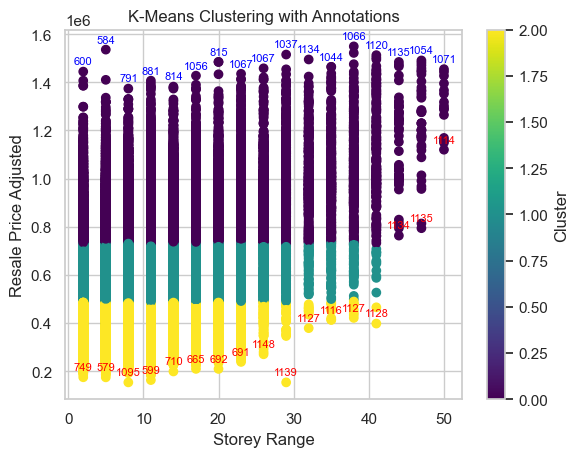

In [140]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
X = df[['avg_storey', 'resale_price_adj']]

kmeans = KMeans(n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(X)

plt.scatter(X['avg_storey'], X['resale_price_adj'], c=y_kmeans, cmap='viridis')

for storey in df['storey_range'].unique():
    storey_data = df[df['storey_range'] == storey]
    lowest_point = storey_data.loc[storey_data['resale_price_adj'].idxmin()]
    plt.annotate(f'{lowest_point["remaining_lease_months"]}', 
                 (lowest_point['avg_storey'], lowest_point['resale_price_adj']),
                 textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='red')
    highest_point = storey_data.loc[storey_data['resale_price_adj'].idxmax()]
    plt.annotate(f'{highest_point["remaining_lease_months"]}', 
                 (highest_point['avg_storey'], highest_point['resale_price_adj']),
                 textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='blue')
plt.title("K-Means Clustering with Annotations")
plt.xlabel("Storey Range")
plt.ylabel("Resale Price Adjusted")
plt.colorbar(label='Cluster')
plt.show()

Insights  
**Clear Price Stratification**: The data shows three distinct price clusters (colored yellow, teal, and purple).  
**Height Premium Pattern**: There's a consistent upward trend in the maximum resale prices as storey range increases, confirming the "higher floor premium" effect in real estate pricing.  
Cluster Boundaries:  

Low cluster (yellow): ~200,000-500,000  
Mid cluster (teal): ~500,000-750,000  
High cluster (purple): ~750,000-1,600,000  

**Price Ceiling Trend**: The highest prices (annotated in blue) show an upward trajectory from storeys 1-40, peaking around the 1,550,000 mark at storeys 35-40.  
**Price Floor Pattern**: The lowest prices (annotated in red) gradually increase with storey height until around storey 40, then they jump significantly higher for the uppermost floors.  
**Diminishing Range at Highest Floors**: Above storey 40, the price spread narrows considerably, with fewer properties in the lowest cluster.  
**Data Density**: The visualization shows more data points in the middle storey ranges (10-40), suggesting these are more common in the housing stock.  
**Outliers**: Several numbered annotations highlight specific properties that represent maximum/minimum values within their storey ranges.  
**High-Rise Premium Cap**: The price premium for height appears to plateau or slightly decrease beyond storey 40, suggesting there may be a ceiling to how much premium buyers will pay for extreme heights.  

This analysis confirms that while higher floors generally command higher prices, the relationship is not purely linear, and other factors likely influence clustering beyond just height of the storeys.

# EDA: Mapping towns
conda install geopandas  
This is something new we learnt.

In [36]:
town_counts = df["town"].value_counts().reset_index()
town_counts.columns = ["town", "count"]
town_coords = {
    "ANG MO KIO": [1.3691, 103.8454],
    "BEDOK": [1.3243, 103.9303],
    "BISHAN": [1.3508, 103.8485],
    "BUKIT BATOK": [1.3590, 103.7513],
    "BUKIT MERAH": [1.2774, 103.8199],
    "BUKIT PANJANG": [1.3838, 103.7613],
    "BUKIT TIMAH": [1.3294, 103.8021],
    "CENTRAL AREA": [1.2897, 103.8501],
    "CHOA CHU KANG": [1.3850, 103.7446],
    "CLEMENTI": [1.3151, 103.7641],
    "GEYLANG": [1.3152, 103.8855],
    "HOUGANG": [1.3710, 103.8928],
    "JURONG EAST": [1.3330, 103.7431],
    "JURONG WEST": [1.3404, 103.7068],
    "KALLANG/WHAMPOA": [1.3195, 103.8651],
    "MARINE PARADE": [1.3021, 103.9057],
    "PASIR RIS": [1.3731, 103.9497],
    "PUNGGOL": [1.4043, 103.9099],
    "QUEENSTOWN": [1.2947, 103.7857],
    "SEMBAWANG": [1.4471, 103.8200],
    "SENGKANG": [1.3915, 103.8950],
    "SERANGOON": [1.3563, 103.8682],
    "TAMPINES": [1.3526, 103.9446],
    "TOA PAYOH": [1.3344, 103.8500],
    "WOODLANDS": [1.4381, 103.7890],
    "YISHUN": [1.4294, 103.8354]
}
town_counts["lat"] = town_counts["town"].map(lambda x: town_coords.get(x, [None, None])[0])
town_counts["lon"] = town_counts["town"].map(lambda x: town_coords.get(x, [None, None])[1])
town_counts = town_counts.dropna()
town_counts["scaled_count"] = (town_counts["count"] / town_counts["count"].max()) * 120  

fig = px.scatter_mapbox(
    town_counts,
    lat="lat",
    lon="lon",
    size="scaled_count",  
    color="count",  
    hover_name="town",
    hover_data={"count": True},
    color_continuous_scale="Viridis",  
    title="Resale Flat Transactions by Town in Singapore",
    zoom=11,
    height=700
)
fig.update_layout(
    mapbox_style="open-street-nao", 
    margin={"r": 0, "t": 50, "l": 0, "b": 0},
    coloraxis_colorbar=dict(title="Transaction Count") 
)
fig.show()

[![Screenshot-2025-04-07-175906.png](https://i.postimg.cc/nL6fB6br/Screenshot-2025-04-07-175906.png)](https://postimg.cc/QBkzrYMZ)

# Getting addresses of hdb

In [44]:
import requests
import pandas as pd
import time
unique_streets = df['street_name'].unique()
street_coords = {}

def get_coordinates(street):
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={street} SINGAPORE&returnGeom=Y&getAddrDetails=Y&pageNum=1"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data["found"] > 0:
            lat = data["results"][0]["LATITUDE"]
            lon = data["results"][0]["LONGITUDE"]
            return float(lat), float(lon)
    return None, None

for street in unique_streets:
    lat, lon = get_coordinates(street)
    street_coords[street] = (lat, lon)
    print(f"{street} → ({lat}, {lon})")
    time.sleep(0.2)

df['latitude'] = df['street_name'].map(lambda x: street_coords[x][0])
df['longitude'] = df['street_name'].map(lambda x: street_coords[x][1])

df.to_csv("lon_lat_17aprilWith2024", index=False)

ANG MO KIO AVE 10 → (1.35968882523895, 103.854575321899)
ANG MO KIO AVE 4 → (1.37231328287072, 103.837601112788)
ANG MO KIO AVE 5 → (1.37634218416684, 103.840158984505)
ANG MO KIO AVE 1 → (1.36013579518176, 103.855025577808)
ANG MO KIO AVE 3 → (1.36619690818888, 103.847756649677)
ANG MO KIO AVE 9 → (1.38403248432085, 103.840356912671)
ANG MO KIO AVE 8 → (1.37742633496685, 103.848699347584)
ANG MO KIO AVE 6 → (1.37048118793194, 103.844805800791)
ANG MO KIO ST 52 → (1.37196445720109, 103.851763531681)
BEDOK NTH AVE 4 → (1.33497991918563, 103.949579950322)
BEDOK NTH AVE 1 → (1.32744916555918, 103.927184430479)
BEDOK NTH RD → (1.33145574028188, 103.935458644142)
BEDOK STH AVE 1 → (1.32085208689731, 103.933721091441)
BEDOK RESERVOIR RD → (1.32808857939361, 103.909877642545)
CHAI CHEE ST → (1.32856339985122, 103.923222454401)
BEDOK NTH ST 3 → (1.33168385606168, 103.922360842039)
BEDOK STH RD → (1.32123665768589, 103.92867661181)
CHAI CHEE AVE → (1.32510368063361, 103.924874310792)
NEW UPP CH

# distance_to_mrt_m

is a continuous numerical variable.
First, we will be loading data from mrt_Stations.csv which contains all the mrt stations existing in 2024 first month, and their longitudes latitudes coordinates. These coordinates will be used to obtain the distance between nearest MRT and the HDB flat.

In [51]:
from geopy.distance import geodesic
mrt_df = pd.read_csv(r"C:\Users\Crystaline\Downloads\mrt_stations.csv")
mrt_df.columns = mrt_df.columns.str.strip()
mrt_df.rename(columns={'Station Name': 'station', 'latitude': 'mrt_lat', 'longitude': 'mrt_lon'}, inplace=True)

def get_nearest_mrt_distance(hdb_lat, hdb_lon, mrt_df):
    hdb_point = (hdb_lat, hdb_lon)
    distances = mrt_df.apply(lambda row: geodesic(hdb_point, (row['mrt_lat'], row['mrt_lon'])).meters, axis=1)
    return distances.min()

df['distance_from_mrt_m'] = df.apply(
    lambda row: get_nearest_mrt_distance(row['latitude'], row['longitude'], mrt_df), axis=1
)

In [54]:
df.rename(columns={'distance_from_mrt_m': 'distance_to_mrt_m'}, inplace=True)

In [55]:
for col in df.columns:
    print(f"📌 Column: {col}")
    print(df[col].unique())
    print("-" * 80)
    print("\n")

📌 Column: month
<DatetimeArray>
['2017-01-01 00:00:00', '2017-02-01 00:00:00', '2017-03-01 00:00:00',
 '2017-04-01 00:00:00', '2017-05-01 00:00:00', '2017-06-01 00:00:00',
 '2017-07-01 00:00:00', '2017-08-01 00:00:00', '2017-09-01 00:00:00',
 '2017-10-01 00:00:00', '2017-11-01 00:00:00', '2017-12-01 00:00:00',
 '2018-01-01 00:00:00', '2018-02-01 00:00:00', '2018-03-01 00:00:00',
 '2018-04-01 00:00:00', '2018-05-01 00:00:00', '2018-06-01 00:00:00',
 '2018-07-01 00:00:00', '2018-08-01 00:00:00', '2018-09-01 00:00:00',
 '2018-10-01 00:00:00', '2018-11-01 00:00:00', '2018-12-01 00:00:00',
 '2019-01-01 00:00:00', '2019-02-01 00:00:00', '2019-03-01 00:00:00',
 '2019-04-01 00:00:00', '2019-05-01 00:00:00', '2019-06-01 00:00:00',
 '2019-07-01 00:00:00', '2019-08-01 00:00:00', '2019-09-01 00:00:00',
 '2019-10-01 00:00:00', '2019-11-01 00:00:00', '2019-12-01 00:00:00',
 '2020-01-01 00:00:00', '2020-02-01 00:00:00', '2020-03-01 00:00:00',
 '2020-04-01 00:00:00', '2020-05-01 00:00:00', '2020-06-01

## Visualising distance_to_mrt_m
This is something new we learnt:  
Folium Map  
pip install folium

In [50]:
import pandas as pd
from geopy.distance import geodesic
mrt_df = pd.read_csv("C:\\Users\\Crystaline\\Downloads\\mrt_stations.csv")
mrt_coords = list(zip(mrt_df['latitude'], mrt_df['longitude']))

def calculate_min_distance(hdb_lat, hdb_lon, mrt_coords):
    return min(geodesic((hdb_lat, hdb_lon), mrt_coord).meters for mrt_coord in mrt_coords)

df['distance_to_mrt_m'] = df.apply(lambda row: calculate_min_distance(row['latitude'], row['longitude'], mrt_coords), axis=1)
df.to_csv("hdb_with_mrt_distance.csv", index=False)
print("🔥 Distances to MRT stations computed and saved.")


KeyboardInterrupt



Now we are going to explore the claim: "Distance to nearest MRT and resale price has a correlation.", using evidence from our data visualise to determine whether the claim is true or false.

In [ ]:
# map
import pandas as pd
from geopy.distance import geodesic
import folium
from folium.plugins import MarkerCluster

mrt_df = pd.read_csv("C:\\Users\\Crystaline\\Downloads\\mrt_stations.csv")
mrt_coords = list(zip(mrt_df['latitude'], mrt_df['longitude']))
def nearest_mrt_distance(hdb_point):
    hdb_coords = (hdb_point['latitude'], hdb_point['longitude'])
    return min(geodesic(hdb_coords, mrt).meters for mrt in mrt_coords)

df['distance_to_mrt_m'] = df.apply(nearest_mrt_distance, axis=1)
sg_center = [1.3521, 103.8198]
m = folium.Map(location=sg_center, zoom_start=12, tiles='CartoDB positron')
for _, row in mrt_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['Station Name'],
        icon=folium.Icon(color='red', icon='train', prefix='fa')
    ).add_to(m)
marker_cluster = MarkerCluster().add_to(m)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        fill=True,
        fill_color='blue', 
        fill_opacity=0.7,
        popup=(
            f"Address: {row['block']} {row['street_name']}<br>"
            f"Resale Price: ${row['resale_price']:,.0f}<br>"
            f"Distance to MRT: {row['distance_to_mrt_m']:.1f} m"
        )
    ).add_to(marker_cluster)
m.save('hdb_resale_map.html')

import branca.colormap as cm
colormap = cm.linear.YlOrRd_09.scale(df['resale_price'].min(), df['resale_price'].max())
fill_color = colormap(row['resale_price'])  # or row['distance_to_mrt_m']

The following images are taken from 'hdb_resale_map.html'

[![Screenshot-2025-04-18-040934.png](https://i.postimg.cc/QCdXNv4B/Screenshot-2025-04-18-040934.png)](https://postimg.cc/9Rs3JgjV)

The nearer to MRT, the higher the resale price of that hdb. But this is not always the case. There are exceptions.

[![Screenshot-2025-04-18-041844.png](https://i.postimg.cc/TYVYfq3v/Screenshot-2025-04-18-041844.png)](https://postimg.cc/D8zKcGGx)

The second example shows: The nearer to MRT, sometimes the lower the resale price.

### Overall Distribution of distance_to_mrt_m:

### Bi-Variate

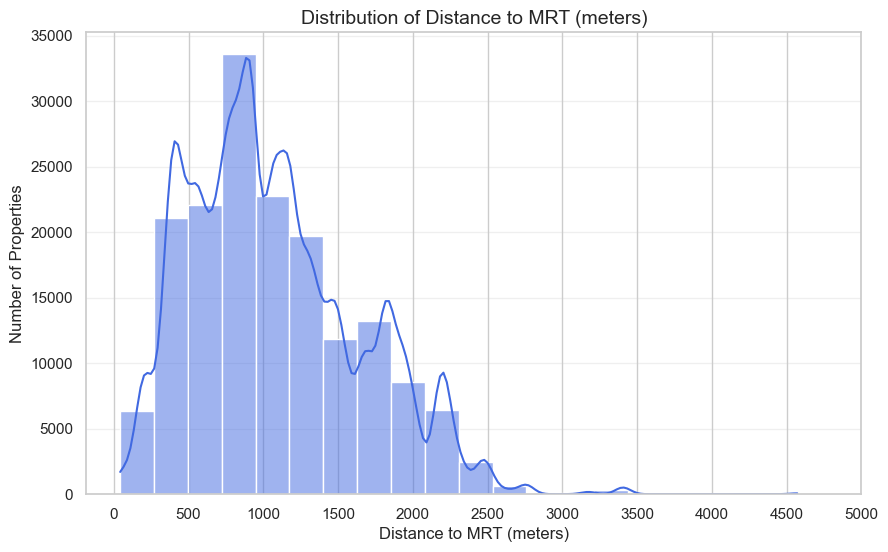

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='distance_to_mrt_m', bins=20, kde=True, color='royalblue')

plt.title('Distribution of Distance to MRT (meters)', fontsize=14)
plt.xlabel('Distance to MRT (meters)', fontsize=12)
plt.ylabel('Number of Properties', fontsize=12)
max_dist = df['distance_to_mrt_m'].max()
plt.xticks(range(0, int(max_dist)+500, 500))
plt.grid(axis='y', alpha=0.3)
plt.show()

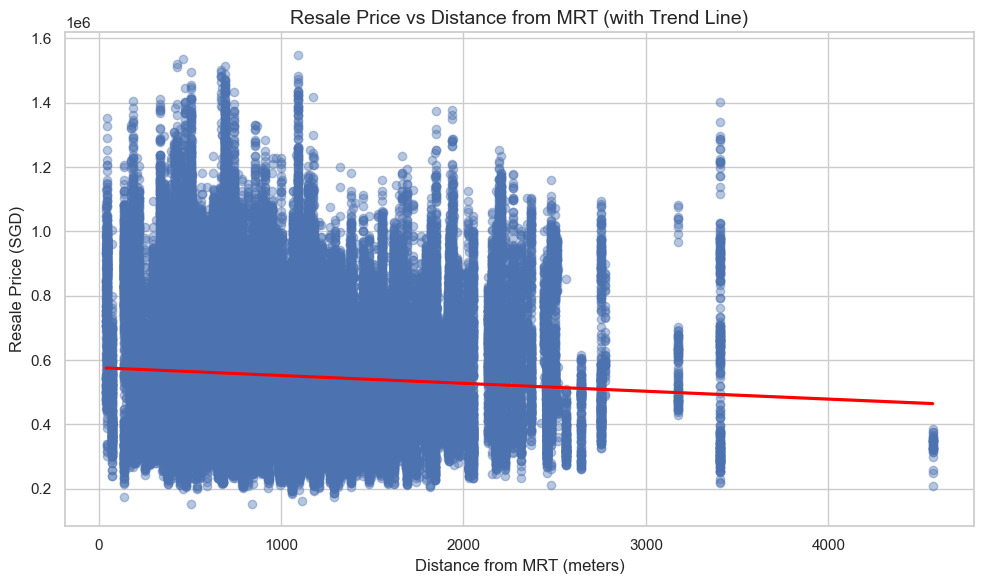

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.regplot(x='distance_to_mrt_m', y='resale_price_adj', data=df, scatter_kws={'alpha':0.4}, line_kws={"color": "red"})
plt.title('Resale Price vs Distance from MRT (with Trend Line)', fontsize=14)
plt.xlabel('Distance from MRT (meters)')
plt.ylabel('Resale Price (SGD)')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Crystaline\AppData\Local\Temp\ipykernel_11268\741279116.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



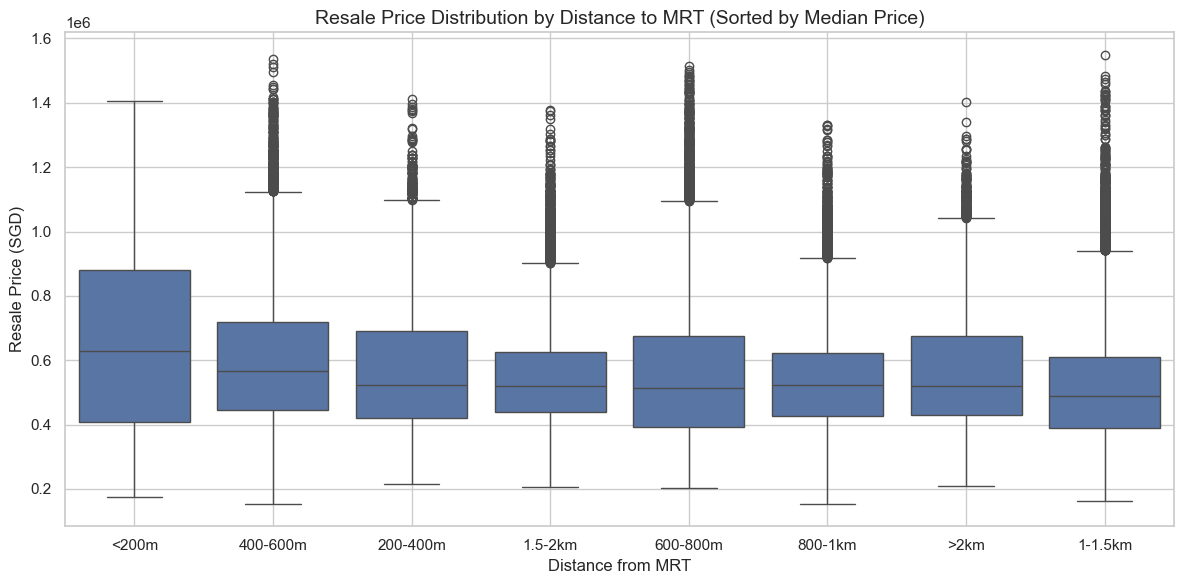

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df['distance_bin'] = pd.cut(
    df['distance_to_mrt_m'],
    bins=[0, 200, 400, 600, 800, 1000, 1500, 2000, float('inf')],
    labels=['<200m', '200-400m', '400-600m', '600-800m', '800-1km', '1-1.5km', '1.5-2km', '>2km']
)

median_prices = df.groupby('distance_bin')['resale_price'].median().sort_values(ascending=False)

sorted_bins = median_prices.index.tolist()

plt.figure(figsize=(12, 6))
sns.boxplot(x='distance_bin', y='resale_price_adj', data=df, order=sorted_bins)
plt.title('Resale Price Distribution by Distance to MRT (Sorted by Median Price)', fontsize=14)
plt.xlabel('Distance from MRT')
plt.ylabel('Resale Price (SGD)')
plt.grid(True)
plt.tight_layout()
plt.show()

Insights
1. **Property Distribution by Distance**: The top histogram shows most properties in the dataset are within 2000 meters of an MRT station, with the highest concentration between 500-1500 meters. This suggests Singapore's urban planning effectively places most housing within reasonable distance of public transit.

2. **Price-Distance Correlation**: The middle scatter plot with trend line demonstrates a clear negative correlation - as distance from MRT increases, property prices generally decrease. However, the shallow slope of the trend line indicates this effect is moderate rather than dramatic.

3. **Price Variability**: Despite the downward trend, there remains significant price variability at all distances, shown by the vertical spread of points at each distance interval. This suggests other factors beyond MRT proximity significantly influence pricing.

4. **Premium for Extreme Proximity**: Properties closest to MRT stations (<200m) show the highest median prices in the boxplot, confirming a premium for extreme convenience.

5. **Non-Linear Relationship**: The boxplot (bottom chart) reveals the relationship isn't purely linear - median prices drop most significantly in the first few distance bands, then stabilize somewhat after 600-800m.

6. **Outliers and Luxury Properties**: High-value outliers exist across all distance bands (visible in both scatter plot and boxplots), indicating premium properties can command high prices regardless of MRT proximity.

7. **Price Floor Consistency**: The lower bounds of prices remain fairly stable across distances, suggesting a baseline housing value independent of MRT access.

8. **Distribution Shape**: The histogram's right-skewed distribution shows fewer properties at extreme distances (>3000m), reflecting Singapore's comprehensive public transit coverage.

These findings confirm that while MRT proximity is a value driver for Singapore properties, it is just one of several factors influencing resale prices, with diminishing impact beyond certain distance thresholds.

# Regression Machine Learning Models
### Single Variate


Regression for floor_area_sqm:
Intercept 	: b = [79252.90731962]
Coefficient 	: a = [[4844.14109573]]

Goodness of Fit 		 Train Dataset
Explained Variance (R²) 	: 0.39673942514529204
Mean Squared Error 		: 20524505664.646736

Goodness of Fit 		 Test Dataset
Explained Variance (R²) 	: 0.3997721788880477
Mean Squared Error 		: 20255394668.43385

Train graph for floor_area_sqm is NOT overfitted!


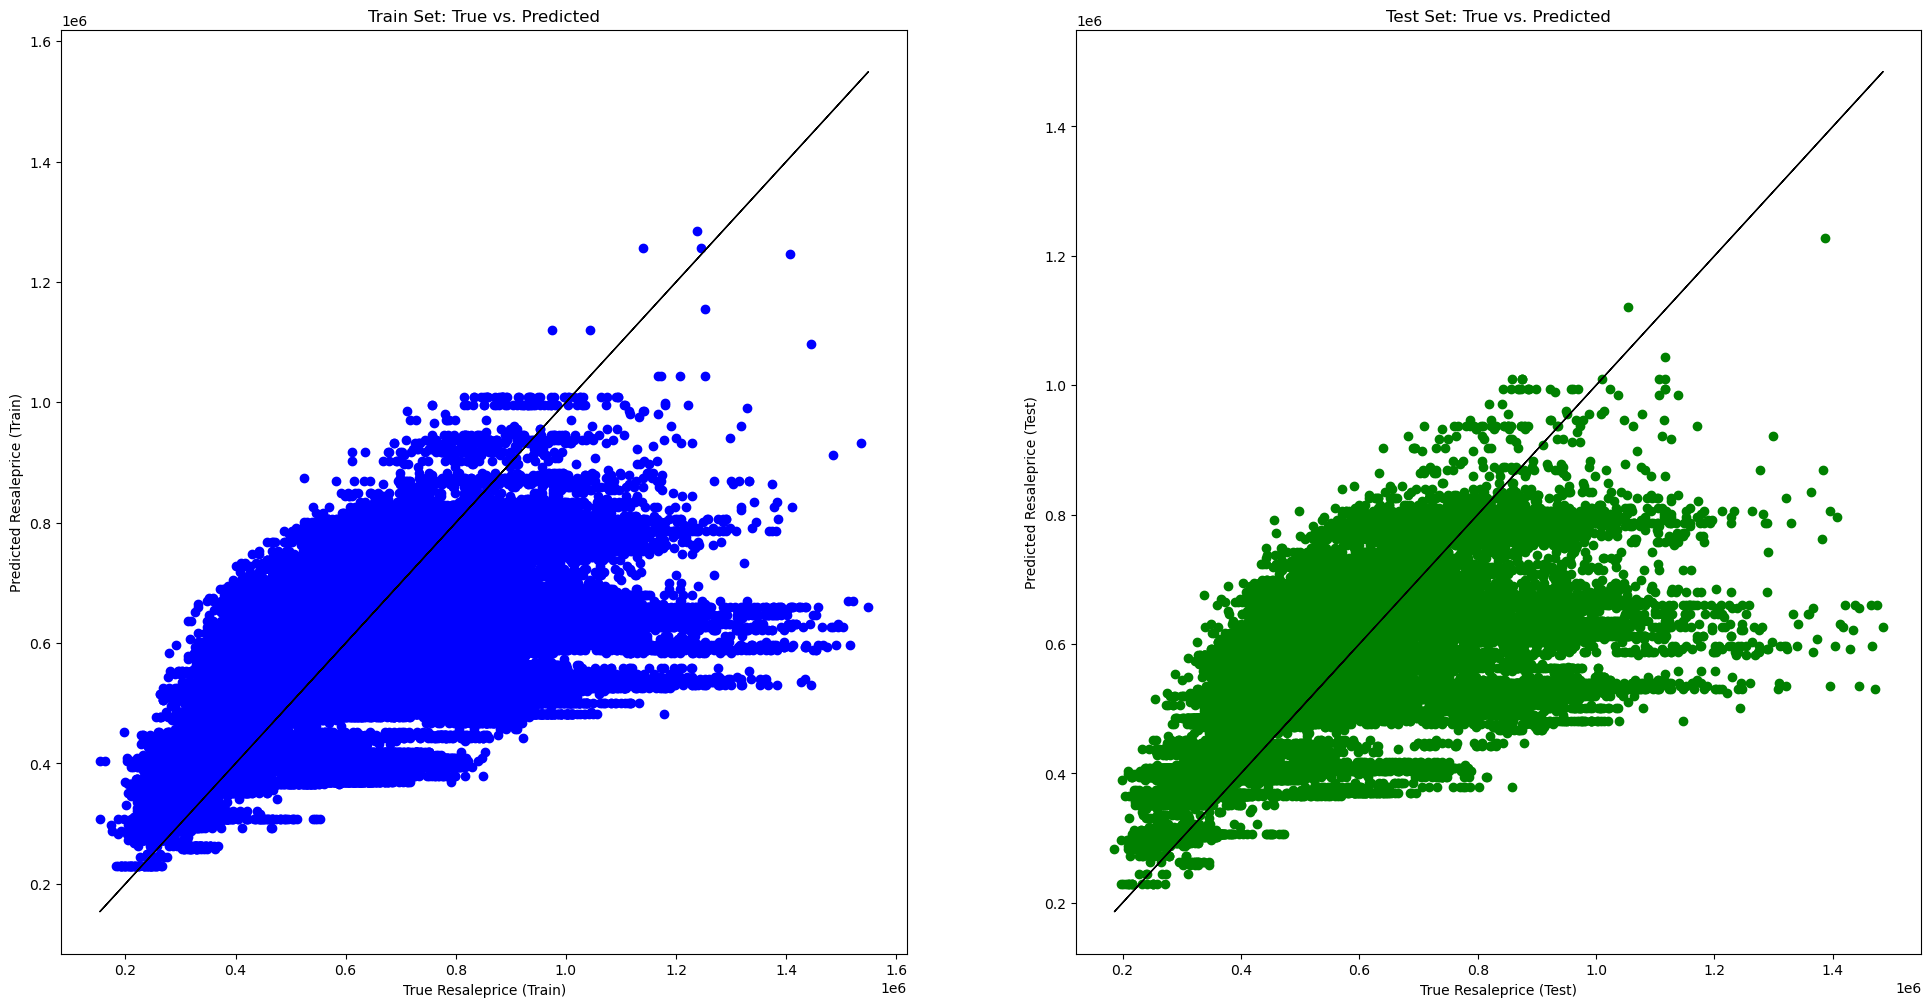


Regression for remaining_lease_months:
Intercept 	: b = [211077.35215309]
Coefficient 	: a = [[378.47807039]]

Goodness of Fit 		 Train Dataset
Explained Variance (R²) 	: 0.1166808477617216
Mean Squared Error 		: 30019525070.7819

Goodness of Fit 		 Test Dataset
Explained Variance (R²) 	: 0.11110764306140031
Mean Squared Error 		: 30131506025.25585

Train graph for remaining_lease_months is NOT overfitted!


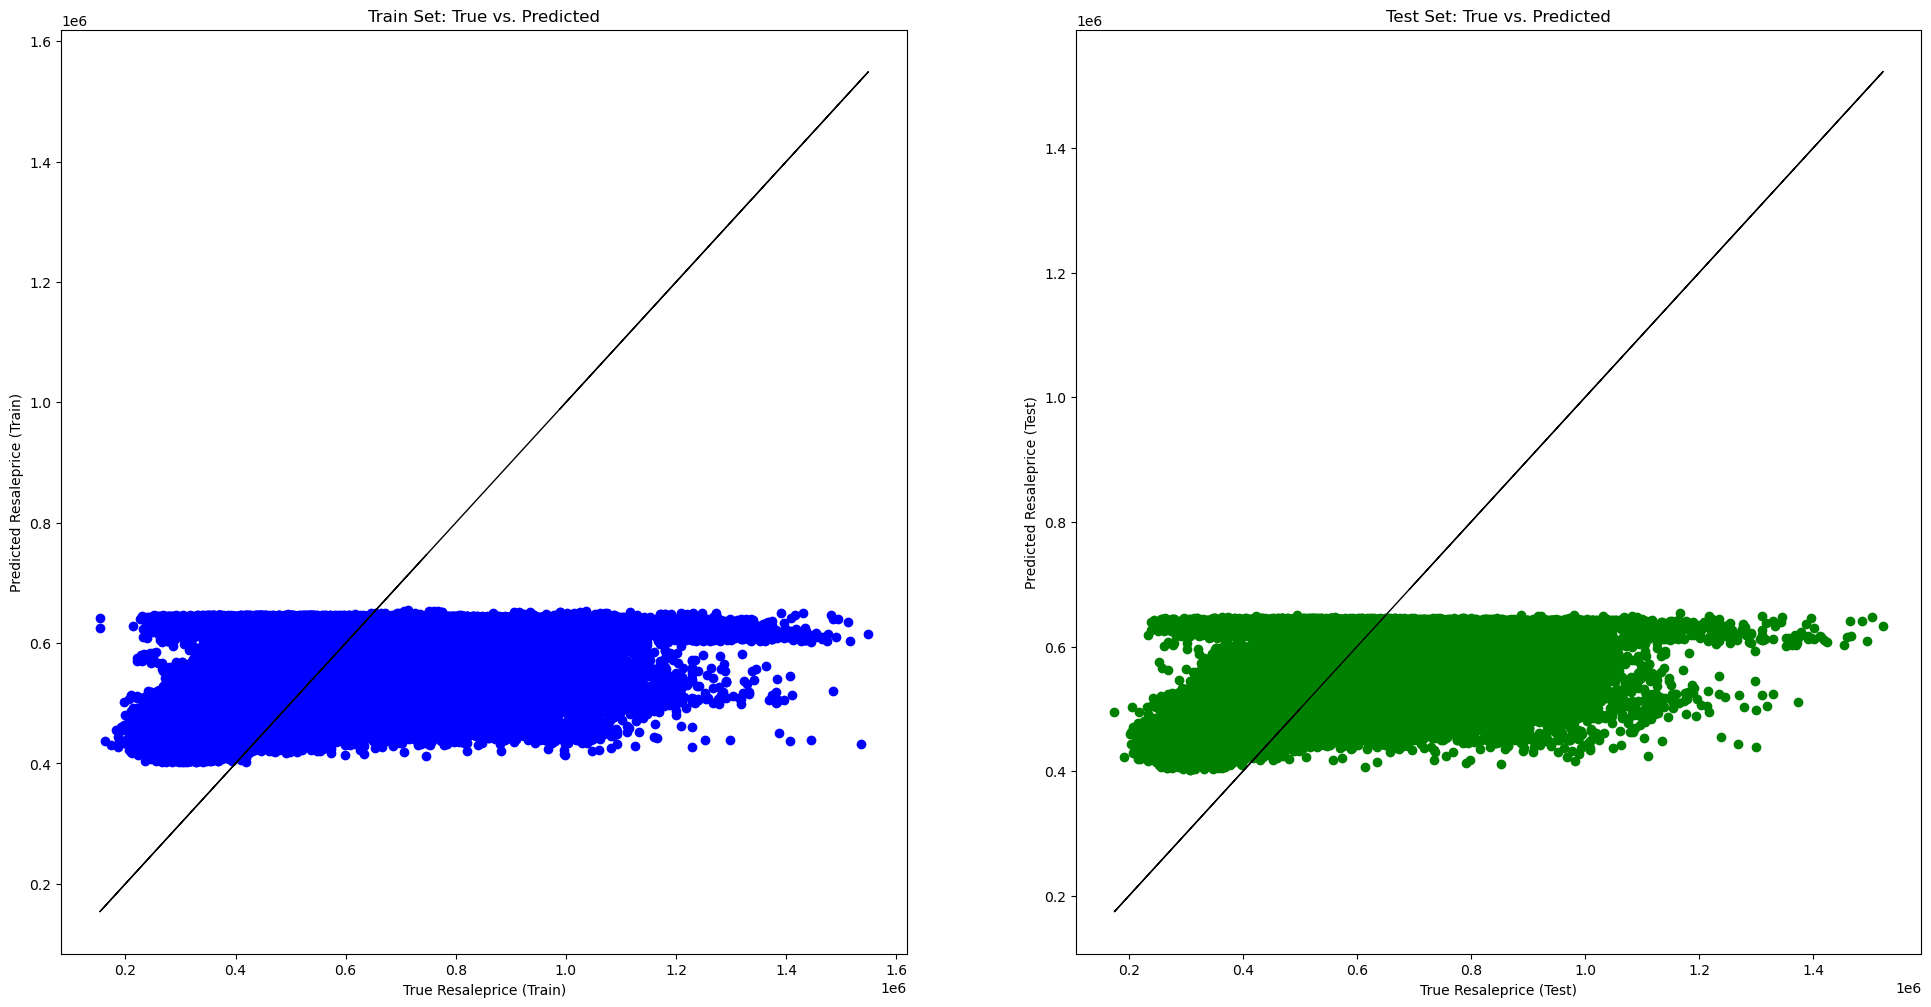


Regression for distance_to_mrt_m:
Intercept 	: b = [579271.65111906]
Coefficient 	: a = [[-26.82873532]]

Goodness of Fit 		 Train Dataset
Explained Variance (R²) 	: 0.00694901556537697
Mean Squared Error 		: 33741241560.297737

Goodness of Fit 		 Test Dataset
Explained Variance (R²) 	: 0.005989570769253438
Mean Squared Error 		: 33725117063.860012

Train graph for distance_to_mrt_m is NOT overfitted!


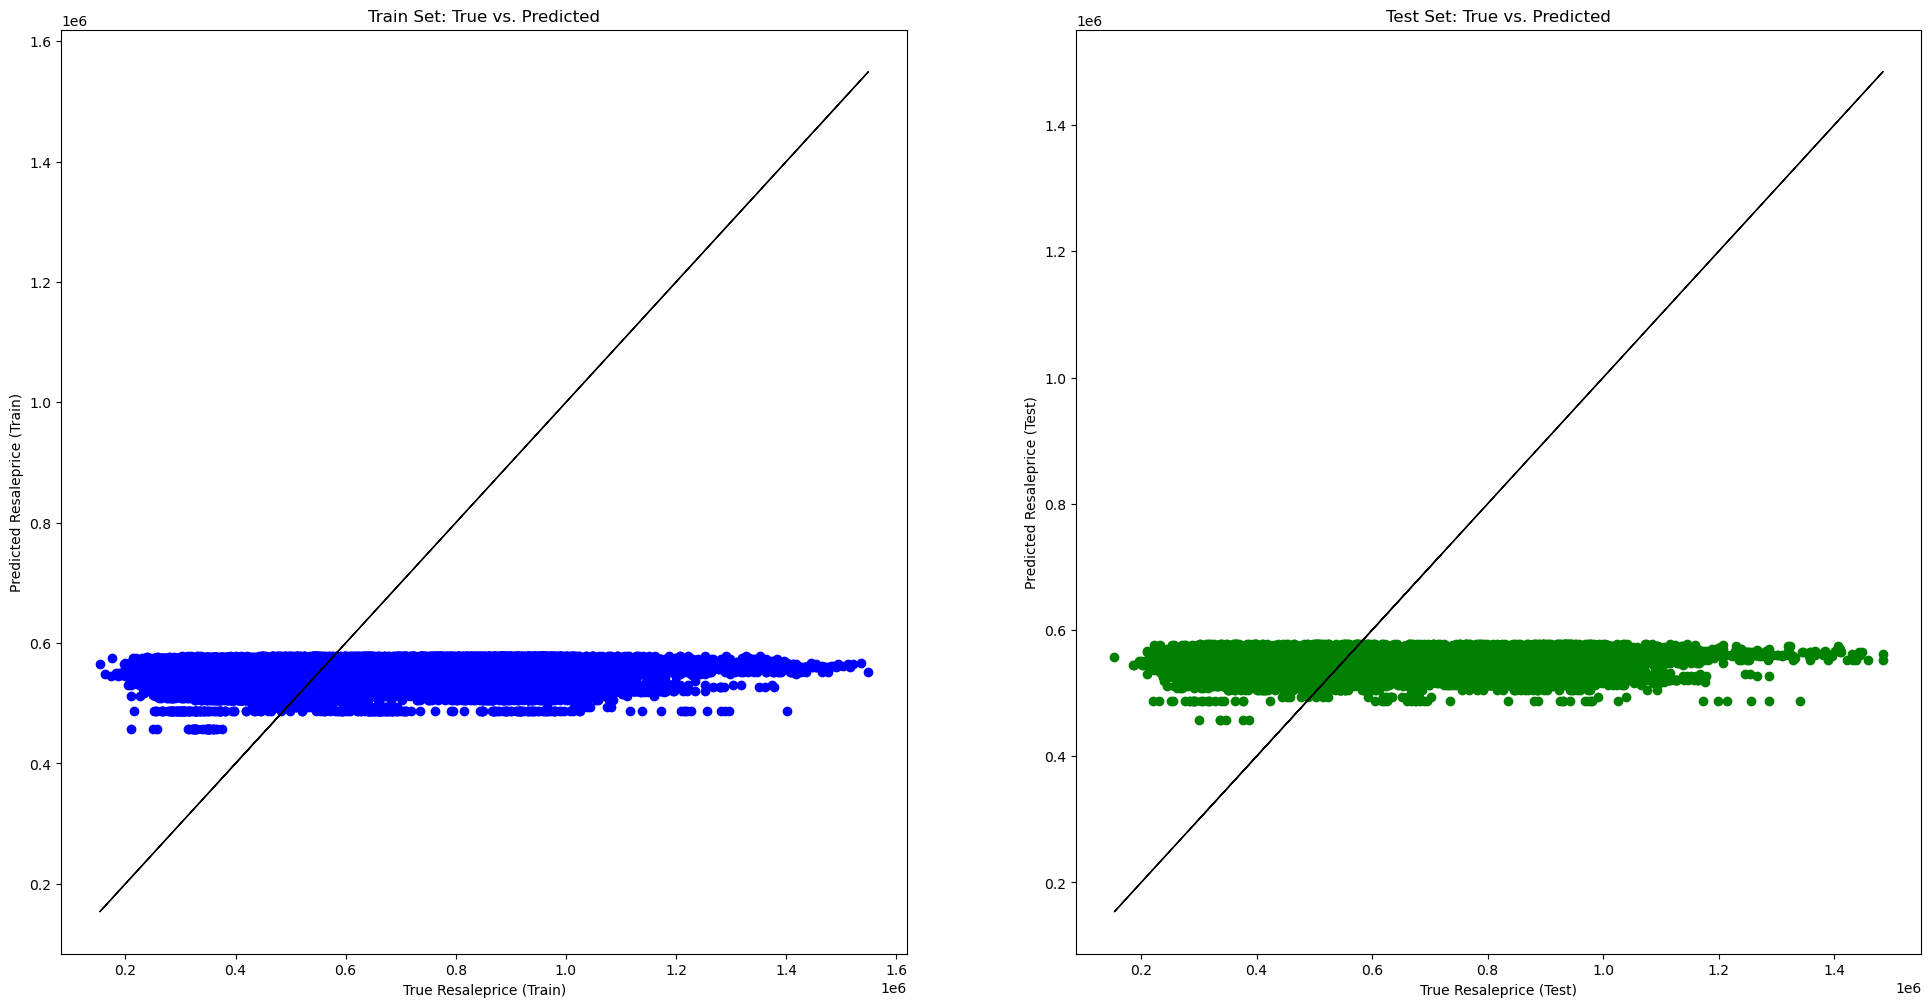

In [21]:
from sklearn.model_selection import train_test_split
def mean_sq_err(actual, predicted):
    return np.mean(np.square(np.array(actual) - np.array(predicted)))

def regression_random_split(feature):
    X = pd.DataFrame(df[feature])  
    y = pd.DataFrame(df['resale_price_adj'])  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    print(f"\nRegression for {feature}:")
    print('Intercept \t: b =', linreg.intercept_)
    print("Coefficient \t: a =", linreg.coef_)
    print()
    y_train_pred = linreg.predict(X_train)
    y_test_pred = linreg.predict(X_test)
    print("Goodness of Fit \t\t Train Dataset")
    print("Explained Variance (R²) \t:", linreg.score(X_train, y_train))
    print("Mean Squared Error \t\t:", mean_sq_err(y_train, y_train_pred))
    print()
    print("Goodness of Fit \t\t Test Dataset")
    print("Explained Variance (R²) \t:", linreg.score(X_test, y_test))
    print("Mean Squared Error \t\t:", mean_sq_err(y_test, y_test_pred))
    print()

    r2_train = linreg.score(X_train, y_train)
    mse_train = mean_sq_err(y_train, y_train_pred)
    r2_test = linreg.score(X_test, y_test)
    mse_test = mean_sq_err(y_test, y_test_pred)

    if r2_train > 0.95:
        print(f'Train graph for {feature} is overfitted!')
    else:
        print(f'Train graph for {feature} is NOT overfitted!')
    f, axes = plt.subplots(1, 2, figsize=(24, 12))
    axes[0].scatter(y_train, y_train_pred, color='blue')
    axes[0].plot(y_train, y_train, 'k-', linewidth=1) 
    axes[0].set_xlabel("True Resaleprice (Train)")
    axes[0].set_ylabel("Predicted Resaleprice (Train)")
    axes[0].set_title("Train Set: True vs. Predicted")

    axes[1].scatter(y_test, y_test_pred, color='green')
    axes[1].plot(y_test, y_test, 'k-', linewidth=1)
    axes[1].set_xlabel("True Resaleprice (Test)")
    axes[1].set_ylabel("Predicted Resaleprice (Test)")
    axes[1].set_title("Test Set: True vs. Predicted")

    plt.show()
    
    r2_test = linreg.score(X_test, y_test)
    mse_test = mean_sq_err(y_test, y_test_pred)

    return r2_test, mse_test 
features = ['floor_area_sqm', 'remaining_lease_months','distance_to_mrt_m']
r2_graph_test = []
mse_graph_test = []

for feature in features:
    r2_test, mse_test = regression_random_split(feature)
    r2_graph_test.append(r2_test)
    mse_graph_test.append(mse_test)

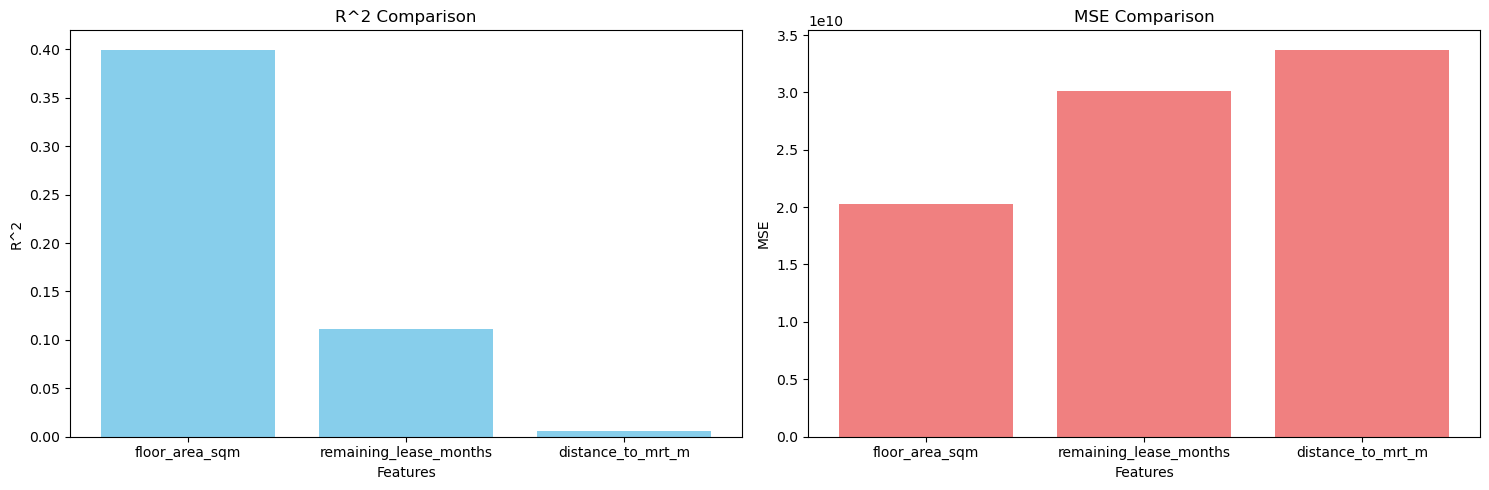

Best model based on highest R² score: floor_area_sqm
Best model based on Prediction Accuracy aka lowest MSE : floor_area_sqm


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].bar(features, r2_graph_test, color='skyblue')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('R^2')
axes[0].set_title('R^2 Comparison')

axes[1].bar(features, mse_graph_test, color='lightcoral')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('MSE')
axes[1].set_title('MSE Comparison')

plt.tight_layout()
plt.show()

best_r2 = np.argmax(r2_graph_test) 
best_r2 = features[best_r2]
print(f'Best model based on highest R² score: {best_r2}')

best_mse = np.argmin(mse_graph_test)
best_mse = features[best_mse]
print(f'Best model based on Prediction Accuracy aka lowest MSE : {best_mse}')

Insight:  
**floor_area_sqm** out of the three numerical variables has the highest R^2 score and lowest mean squared error.

**remaining lease in terms of months**  
The linear regression between the remaining_lease in terms of months and resale price has a poor predictive power, R^2 is 0.1, suggesting lease decay alone does not drive resale prices. Contrary to public perception, the age of flats, or in other words the remaining lease, weakly affects the resale prices. Lease decay does affect resale prices to some extent—but not as strongly as many people assume. Here are some possible reasons:

1. Market Sentiment Remains Resilient
Despite concerns, data shows that resale prices of older HDB flats are not crashing. In fact, the number of million-dollar resale flats—including older ones—is rising. This indicates that other factors like size, location, and scarcity of large units matter more to buyers.

2. Government Support Helps Mitigate Concerns
Policies like the Voluntary En-bloc Redevelopment Scheme (VERS) and ongoing discussions about lease buyback and upgrading offer homeowners greater security and keep confidence in the resale market relatively stable.

**distance_to_mrt_m**    
Here are possible reasons for its weak predictive power on resale price in our model:  


1. **Non-linear or Threshold Effects**  
- Buyers might only care whether a flat is near an MRT (e.g., within 500m or 1km), not the exact distance.  
- So whether it is 200m or 400m might not matter much — both are close.  
- Beyond a certain distance (say >1km), price sensitivity drops significantly.  

2. **Measurement Noise**  
- The distance computed was using straight-line distance instead of actual walking paths, in order to minimise the computational time in retrieving the distance_to_mrt_m. However, euclidean distance can be misleading — a flat might be 300m away but separated by highways or walls.

**last words**  
The low accuracy across these three factors suggests that no single feature could sufficiently explain resale prices, affirming the complexity of real estate valuation.

# Regression
### Multi Variate


Multivariate Regression:
Intercept 	: 549735.7566362439
Coefficients 	: [109624.50961208  48761.2109983  -15803.64776443]

Goodness of Fit (Train Dataset):
Explained Variance (R²): 0.47188090061527566
Mean Squared Error (MSE): 17851517220.14021

Goodness of Fit (Test Dataset):
Explained Variance (R²): 0.47750607481515206
Mean Squared Error (MSE): 18116175343.93269


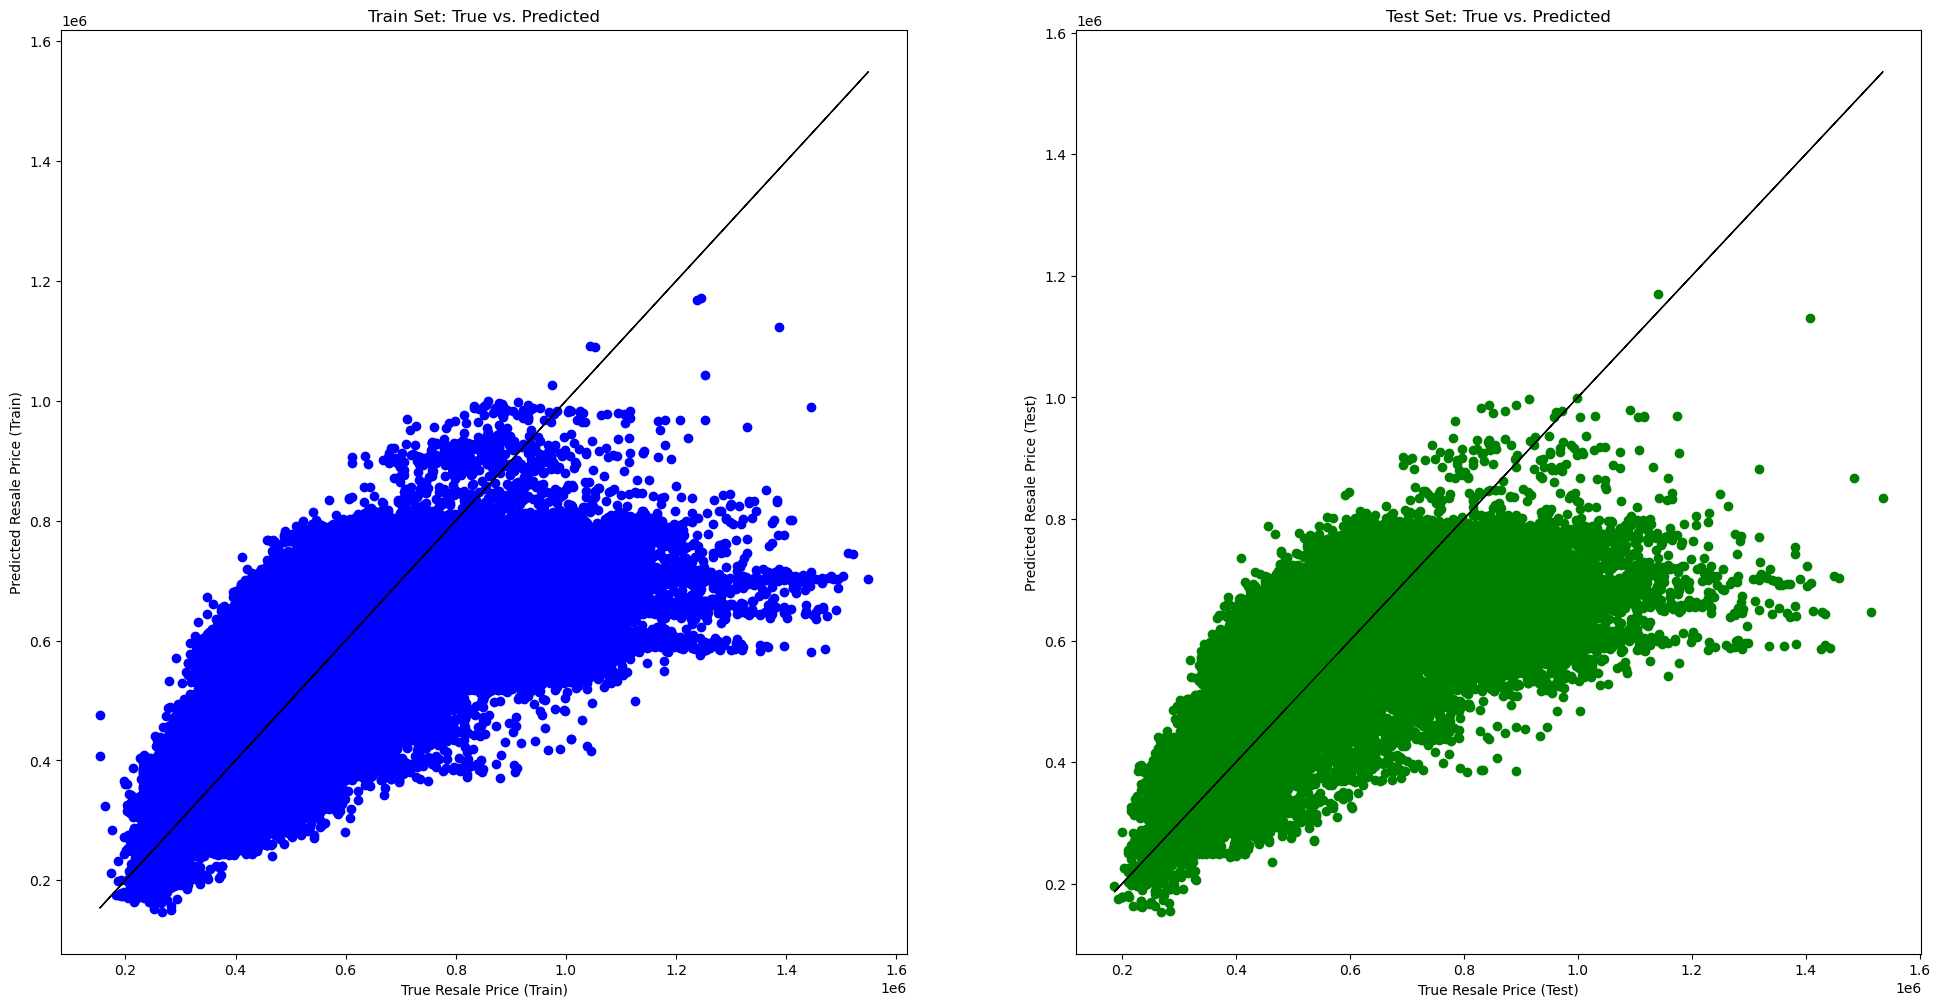

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

def mean_sq_err(actual, predicted):
    return np.mean(np.square(np.array(actual) - np.array(predicted)))

def multivariate_regression(features):
    X = df[features]
    y = df['resale_price_adj'] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    linreg = LinearRegression()
    linreg.fit(X_train_scaled, y_train)

    y_train_pred = linreg.predict(X_train_scaled)
    y_test_pred = linreg.predict(X_test_scaled)

    print("\nMultivariate Regression:")
    print('Intercept \t:', linreg.intercept_)
    print("Coefficients \t:", linreg.coef_)

    print("\nGoodness of Fit (Train Dataset):")
    print("Explained Variance (R²):", r2_score(y_train, y_train_pred))
    print("Mean Squared Error (MSE):", mean_sq_err(y_train, y_train_pred))

    print("\nGoodness of Fit (Test Dataset):")
    print("Explained Variance (R²):", r2_score(y_test, y_test_pred))
    print("Mean Squared Error (MSE):", mean_sq_err(y_test, y_test_pred))

    f, axes = plt.subplots(1, 2, figsize=(24, 12))
    axes[0].scatter(y_train, y_train_pred, color='blue')
    axes[0].plot(y_train, y_train, 'k-', linewidth=1)
    axes[0].set_xlabel("True Resale Price (Train)")
    axes[0].set_ylabel("Predicted Resale Price (Train)")
    axes[0].set_title("Train Set: True vs. Predicted")

    axes[1].scatter(y_test, y_test_pred, color='green')
    axes[1].plot(y_test, y_test, 'k-', linewidth=1)
    axes[1].set_xlabel("True Resale Price (Test)")
    axes[1].set_ylabel("Predicted Resale Price (Test)")
    axes[1].set_title("Test Set: True vs. Predicted")

    plt.show()
    return linreg.coef_, linreg.intercept_  
features = ['floor_area_sqm', 'remaining_lease_months', 'distance_to_mrt_m']
coefficients, intercept = multivariate_regression(features)

Insights:  
Multi-Variate Regression Accuracy in terms of R square score and MSE are higher than all of the Single-Variate Regresion, showing that in predicting resale prices, it is an interplacy of factors, and not solely dependent on just one numerical variable. Therefore, Multi-Variate is preferred over to Single-Variate Regression Model.   

Also, this revealed a key insight: resale prices are influenced by a combination of factors, **not isolated attributes**. However, the linear model was still limited in capturing non-linear relationships.

# Regression

### K-Nearest Neighbors KNN
a regression ML, predicts the resale price of HDB flats by averaging the prices of the 5 nearest neighbors in the feature space, after scaling the input features.

C:\Users\Crystaline\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



RMSE: 68624.99
R² Score: 0.8642


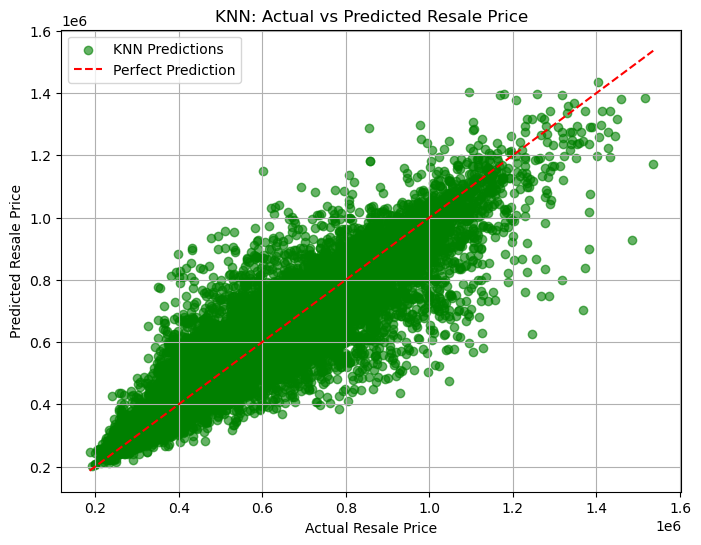

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = df[['floor_area_sqm', 'remaining_lease_months','distance_to_mrt_m']].values
y = df['resale_price_adj'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
knn = KNeighborsRegressor(n_neighbors=5) 
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='green', label='KNN Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('KNN: Actual vs Predicted Resale Price')
plt.legend()
plt.grid(True)
plt.show()

Insights:  
This is something new we learnt:  
To improve model performance, we turned to K-Nearest Neighbors (KNN) regression. Unlike traditional models, KNN is instance-based and non-parametric. It does not make prior assumptions about the data distribution, but instead makes predictions by referencing nearby points in the training set.  
Features Used: Floor Area, Remaining Lease, Distance to MR  T
Preprocessing: Data scaling appli  ed
Evaluation Metrics: RMSE and R² Sc  ore

KNN significantly outperformed the previous models with an R² score of 86%, capturing non-linear patterns that linear models missed. This model highlighted the strength of memory-based learning for dynamic real-world   data.

### Support Vector Regressor (SVR)
a non-linear svm regression model

Goodness of Fit 		 Train Dataset
Explained Variance (R²) 	: 0.6009640455066032
Mean Squared Error 		: 13488240098.4796

Goodness of Fit 		 Test Dataset
Explained Variance (R²) 	: 0.5995907454744882
Mean Squared Error 		: 13883193496.9412


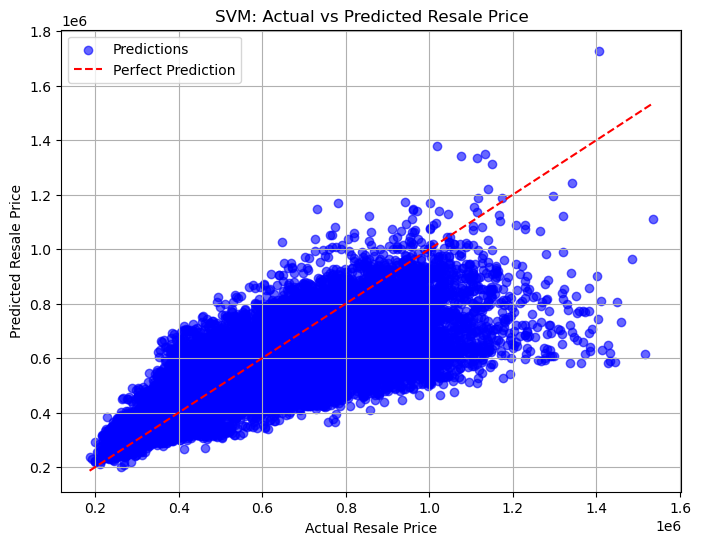

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

features = ['floor_area_sqm', 'remaining_lease_months', 'distance_to_mrt_m']
target = 'resale_price_adj'

X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

svr = SVR(kernel='rbf', C=100, epsilon=0.1)
svr.fit(X_train_scaled, y_train_scaled)

y_train_pred_scaled = svr.predict(X_train_scaled)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_pred_scaled = svr.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)

print("Goodness of Fit \t\t Train Dataset")
print(f"Explained Variance (R²) \t: {r2_train}")
print(f"Mean Squared Error \t\t: {mse_train:.4f}\n")

print("Goodness of Fit \t\t Test Dataset")
print(f"Explained Variance (R²) \t: {r2_test}")
print(f"Mean Squared Error \t\t: {mse_test:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('SVM: Actual vs Predicted Resale Price')
plt.legend()
plt.grid(True)
plt.show()

Insights:  
Moderate Accuracy: The model captures general pricing trends, but predictions show noticeable variance, especially for outliers.  
Systematic Bias: SVR tends to overestimate lower-value properties and underestimate higher-value ones.
Error Spread: A relatively high Mean Squared Error (13.4M–13.8M) indicates significant unexplained variance.  
Outlier Sensitivity: Predictions are least reliable for top-tier properties (1.5M SGD).  
Best Performance Range: Predictions are most stable in the 600k–1M SGD range, where data is denser.  

While SVR improves on linear regression (48% R²), it lags behind KNN’s ability to capture complex, non-linear patterns. Still, its stable performance across datasets makes it a viable option for moderate-precision use cases, particularly where model interpretability and consistency are valued. The best model to use will be: KNN.

# Classification ML
### CatBoost
#### 3 Bin

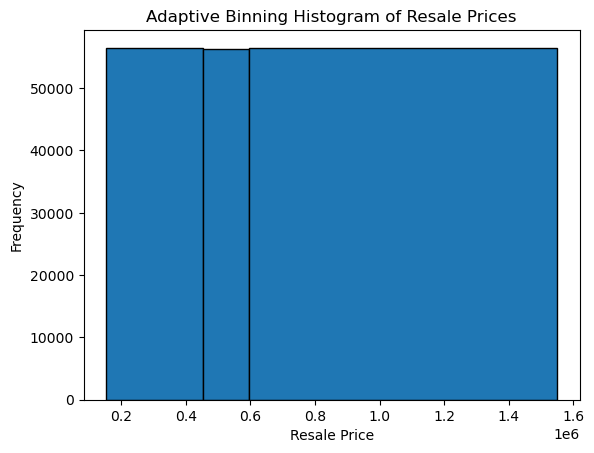

resale_price_category
Bin 2    56439
Bin 1    56408
Bin 3    56326
Name: count, dtype: int64
Bin edges (resale price percentiles):
0: 153,584.67
1: 452,562.82
2: 594,447.16
3: 1,549,310.22
0:	learn: 1.0701790	total: 530ms	remaining: 4m 24s
100:	learn: 0.5100136	total: 36.4s	remaining: 2m 23s
200:	learn: 0.4935290	total: 1m 12s	remaining: 1m 48s
300:	learn: 0.4885061	total: 1m 50s	remaining: 1m 13s
400:	learn: 0.4857181	total: 2m 27s	remaining: 36.3s
499:	learn: 0.4838671	total: 3m 3s	remaining: 0us
Classification Report:
               precision    recall  f1-score   support

       Bin 1       0.87      0.80      0.83     11250
       Bin 2       0.64      0.74      0.69     11129
       Bin 3       0.85      0.78      0.81     11456

    accuracy                           0.78     33835
   macro avg       0.79      0.78      0.78     33835
weighted avg       0.79      0.78      0.78     33835

Accuracy: 0.7760
Confusion Matrix:
 [[9038 2142   70]
 [1349 8267 1513]
 [  57 2447 8952]]


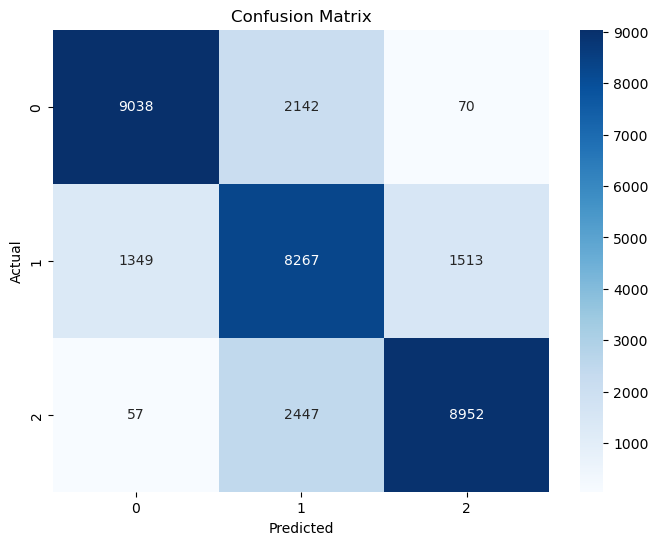

In [67]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_categ = df[['town', 'flat_type', 'storey_range', 'flat_model']].copy()
n_bins = 3
bin_edges = np.percentile(df['resale_price_adj'], np.linspace(0, 100, n_bins + 1))
df_categ['resale_price_category'] = pd.cut(df['resale_price_adj'], bins=bin_edges, labels=[f'Bin {i+1}' for i in range(n_bins)], include_lowest=True).astype(str)

plt.hist(df['resale_price_adj'], bins=bin_edges, edgecolor='black', align='mid')
plt.title("Adaptive Binning Histogram of Resale Prices")
plt.xlabel("Resale Price")
plt.ylabel("Frequency")
plt.show()

print(df_categ['resale_price_category'].value_counts())
print("Bin edges (resale price percentiles):")
for i, edge in enumerate(bin_edges):
    print(f"{int(i)}: {edge:,.2f}")

def train_and_evaluate_catboost(df, target_col, cat_features):
    df = df.copy()
    for col in cat_features:
        if df[col].dtype == 'object':
            df.loc[:, col] = df[col].str.extract(r'(\d+)')[0].fillna(df[col]).astype(str)
    for col in cat_features:
        df.loc[:, col] = df[col].astype(str)
    X = df.drop(columns=[target_col])
    y = df[target_col].astype(str)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.05, loss_function='MultiClass', verbose=100)
    model.fit(X_train, y_train, cat_features=cat_features)
    y_pred = model.predict(X_test).ravel()
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"Accuracy: {(y_pred == y_test).mean():.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

cat_features = ['town', 'flat_type', 'storey_range', 'flat_model']
train_and_evaluate_catboost(df_categ, target_col='resale_price_category', cat_features=cat_features)

#### 5 Bin

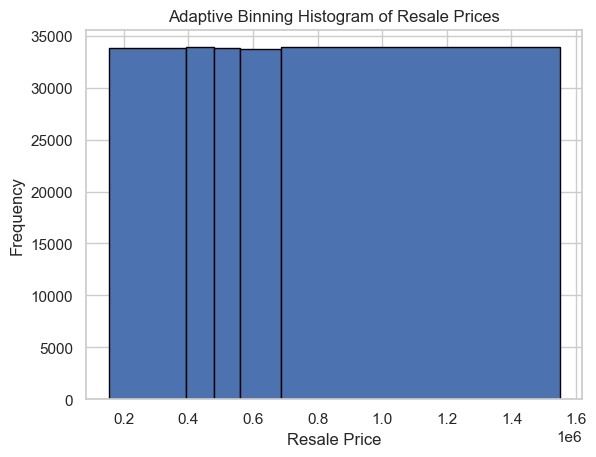

resale_price_category
Bin 1    33899
Bin 4    33875
Bin 3    33832
Bin 5    33794
Bin 2    33773
Name: count, dtype: int64
Bin edges (resale price percentiles):
0: 153,584.67
1: 391,786.44
2: 479,602.65
3: 560,514.94
4: 687,693.78
5: 1,549,310.22
0:	learn: 1.5532086	total: 676ms	remaining: 5m 37s
100:	learn: 0.8573067	total: 1m 14s	remaining: 4m 52s
200:	learn: 0.8282262	total: 2m 27s	remaining: 3m 39s
300:	learn: 0.8186798	total: 3m 40s	remaining: 2m 25s
400:	learn: 0.8137683	total: 4m 54s	remaining: 1m 12s
499:	learn: 0.8102013	total: 6m 7s	remaining: 0us
Classification Report:
               precision    recall  f1-score   support

       Bin 1       0.79      0.83      0.81      6742
       Bin 2       0.52      0.48      0.50      6697
       Bin 3       0.47      0.49      0.48      6702
       Bin 4       0.54      0.55      0.55      6779
       Bin 5       0.82      0.79      0.80      6915

    accuracy                           0.63     33835
   macro avg       0.63      0.6

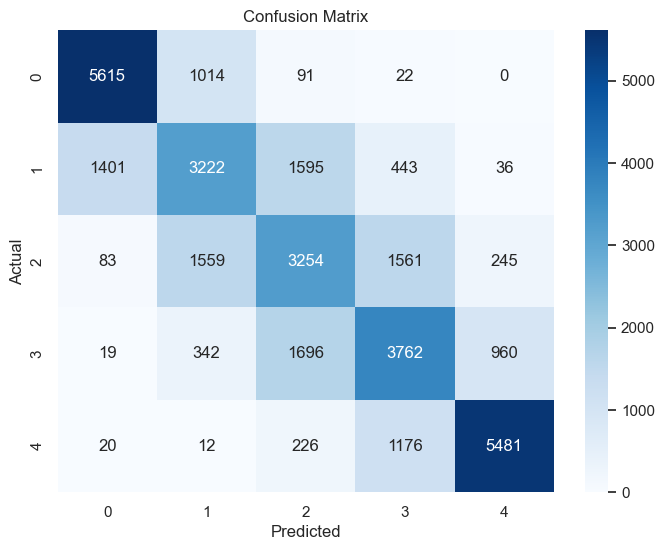

In [87]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_categ = df[['town', 'flat_type', 'storey_range', 'flat_model']].copy()
n_bins = 5
bin_edges = np.percentile(df['resale_price_adj'], np.linspace(0, 100, n_bins + 1))
df_categ['resale_price_category'] = pd.cut(df['resale_price_adj'], bins=bin_edges, labels=[f'Bin {i+1}' for i in range(n_bins)], include_lowest=True).astype(str)

plt.hist(df['resale_price_adj'], bins=bin_edges, edgecolor='black', align='mid')
plt.title("Adaptive Binning Histogram of Resale Prices")
plt.xlabel("Resale Price")
plt.ylabel("Frequency")
plt.show()

print(df_categ['resale_price_category'].value_counts())
print("Bin edges (resale price percentiles):")
for i, edge in enumerate(bin_edges):
    print(f"{int(i)}: {edge:,.2f}")

def train_and_evaluate_catboost(df, target_col, cat_features):
    df = df.copy()
    for col in cat_features:
        if df[col].dtype == 'object':
            df.loc[:, col] = df[col].str.extract(r'(\d+)')[0].fillna(df[col]).astype(str)
    for col in cat_features:
        df.loc[:, col] = df[col].astype(str)
    X = df.drop(columns=[target_col])
    y = df[target_col].astype(str)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.05, loss_function='MultiClass', verbose=100)
    model.fit(X_train, y_train, cat_features=cat_features)
    y_pred = model.predict(X_test).ravel()
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"Accuracy: {(y_pred == y_test).mean():.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

cat_features = ['town', 'flat_type', 'storey_range', 'flat_model']
train_and_evaluate_catboost(df_categ, target_col='resale_price_category', cat_features=cat_features)

#### 8 Bin

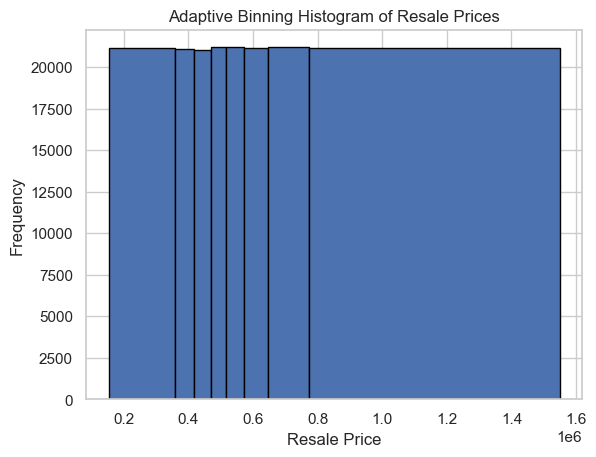

resale_price_category
Bin 5    21362
Bin 7    21276
Bin 2    21223
Bin 3    21217
Bin 1    21150
Bin 4    21026
Bin 8    21013
Bin 6    20906
Name: count, dtype: int64
Bin edges (resale price percentiles):
0: 153,584.67
1: 357,217.66
2: 415,807.52
3: 470,123.64
4: 517,791.07
5: 573,382.75
6: 645,784.37
7: 772,839.00
8: 1,549,310.22
0:	learn: 2.0108435	total: 1.67s	remaining: 13m 55s
100:	learn: 1.2390975	total: 2m 50s	remaining: 11m 13s
200:	learn: 1.2029291	total: 5m 33s	remaining: 8m 16s
300:	learn: 1.1891126	total: 8m 17s	remaining: 5m 29s
400:	learn: 1.1818553	total: 11m 2s	remaining: 2m 43s
499:	learn: 1.1766565	total: 13m 43s	remaining: 0us
Classification Report:
               precision    recall  f1-score   support

       Bin 1       0.68      0.77      0.73      4201
       Bin 2       0.42      0.46      0.44      4254
       Bin 3       0.41      0.28      0.33      4240
       Bin 4       0.31      0.31      0.31      4022
       Bin 5       0.35      0.31      0.33      4

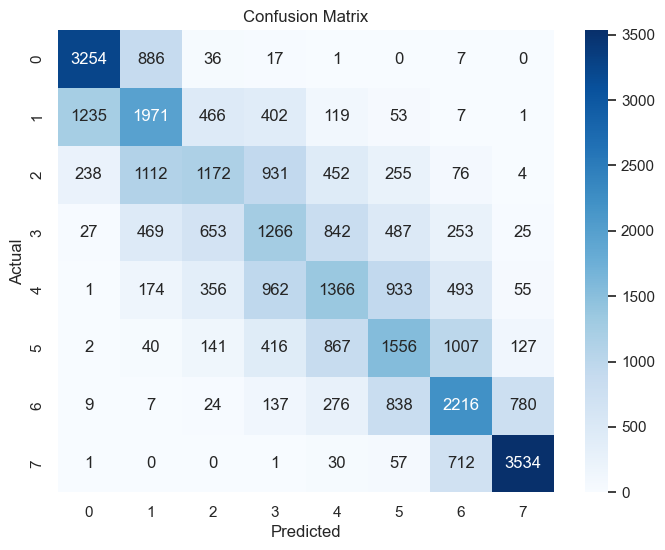

In [86]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_categ = df[['town', 'flat_type', 'storey_range', 'flat_model']].copy()
n_bins = 8
bin_edges = np.percentile(df['resale_price_adj'], np.linspace(0, 100, n_bins + 1))
df_categ['resale_price_category'] = pd.cut(df['resale_price_adj'], bins=bin_edges, labels=[f'Bin {i+1}' for i in range(n_bins)], include_lowest=True).astype(str)

plt.hist(df['resale_price_adj'], bins=bin_edges, edgecolor='black', align='mid')
plt.title("Adaptive Binning Histogram of Resale Prices")
plt.xlabel("Resale Price")
plt.ylabel("Frequency")
plt.show()

print(df_categ['resale_price_category'].value_counts())
print("Bin edges (resale price percentiles):")
for i, edge in enumerate(bin_edges):
    print(f"{int(i)}: {edge:,.2f}")

def train_and_evaluate_catboost(df, target_col, cat_features):
    df = df.copy()
    for col in cat_features:
        if df[col].dtype == 'object':
            df.loc[:, col] = df[col].str.extract(r'(\d+)')[0].fillna(df[col]).astype(str)
    for col in cat_features:
        df.loc[:, col] = df[col].astype(str)
    X = df.drop(columns=[target_col])
    y = df[target_col].astype(str)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.05, loss_function='MultiClass', verbose=100)
    model.fit(X_train, y_train, cat_features=cat_features)
    y_pred = model.predict(X_test).ravel()
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"Accuracy: {(y_pred == y_test).mean():.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

cat_features = ['town', 'flat_type', 'storey_range', 'flat_model']
train_and_evaluate_catboost(df_categ, target_col='resale_price_category', cat_features=cat_features)

Insights:  
Adaptive binning is something new we learnt and through adaptive binning of price range, we effectively prevent imbalance of data. We also know that the prices goes as low as 160k to as high as 1.6 million, so binning needs to be effective. We Trial and error with 3,5 and 8 bins respectively together with variables like Town, Flat type, models and Storey. Looking at the results, we can see that 3 bins worked the best but comes at a limitation of over generalising of the results, while 8 being more precise in the price range prediction gave a lower accuracy. This means that 5 bins seems a better one.

### XGBoost

Classification ML

Class distribution:
 resale_price_bin
0    33899
1    33773
2    33832
3    33875
4    33794
Name: count, dtype: int64


C:\Users\Crystaline\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning:

[01:25:30] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Fit time: 36.759888887405396
Predict time: 3.4898886680603027
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81      6742
           1       0.53      0.47      0.50      6697
           2       0.48      0.47      0.48      6702
           3       0.54      0.58      0.56      6779
           4       0.82      0.79      0.80      6915

    accuracy                           0.63     33835
   macro avg       0.63      0.63      0.63     33835
weighted avg       0.63      0.63      0.63     33835

Classification Accuracy: 0.6324


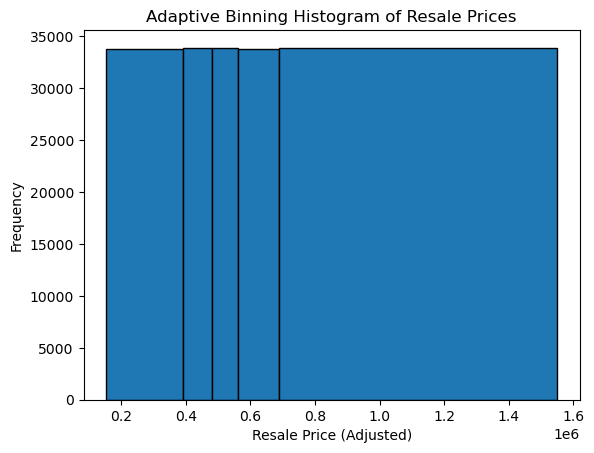

Bin edges (resale price percentiles):
0: 153,584.67
1: 391,786.44
2: 479,602.65
3: 560,514.94
4: 687,693.78
5: 1,549,310.22


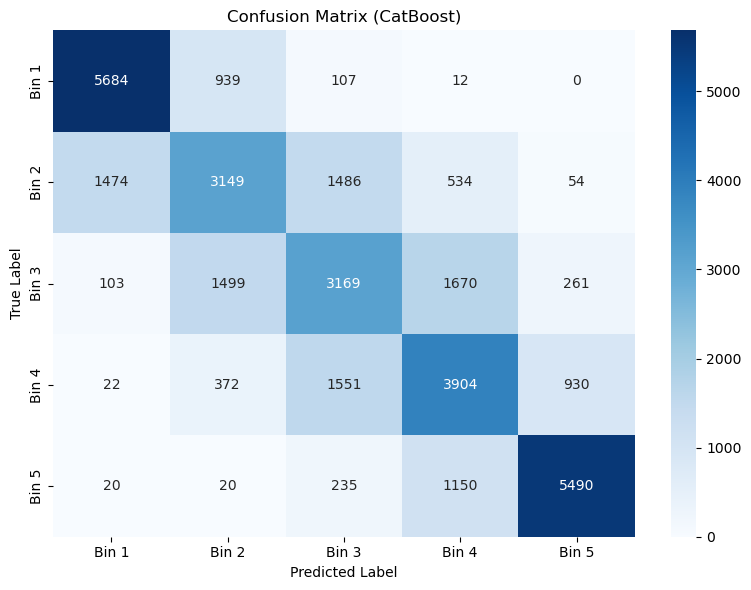

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

n_bins = 5
bin_edges = np.percentile(df['resale_price_adj'], np.linspace(0, 100, n_bins + 1))

df['resale_price_bin'] = pd.cut(
    df['resale_price_adj'], 
    bins=bin_edges, 
    labels=False, 
    include_lowest=True
)

df = df.dropna(subset=['resale_price_bin'])
df['resale_price_bin'] = df['resale_price_bin'].astype(int)  

features = ['town', 'flat_type', 'avg_storey', 'flat_model']
X = df[features]
y = df['resale_price_bin']

print("Class distribution:\n", y.value_counts().sort_index())

categorical_features = ['town', 'flat_type', 'avg_storey', 'flat_model']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        colsample_bytree=0.8,
        learning_rate=0.05,
        max_depth=10,
        n_estimators=300,
        subsample=0.8
    ))
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start = time.time()
pipeline.fit(X_train, y_train)
print("Fit time:", time.time() - start)

start = time.time()
y_pred = pipeline.predict(X_test)
print("Predict time:", time.time() - start)

print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.4f}")
plt.hist(df['resale_price_adj'], bins=bin_edges, edgecolor='black')
plt.title("Adaptive Binning Histogram of Resale Prices")
plt.xlabel("Resale Price (Adjusted)")
plt.ylabel("Frequency")
plt.show()
print("Bin edges (resale price percentiles):")
for i, edge in enumerate(bin_edges):
    print(f"{i}: {edge:,.2f}")
import seaborn as sns
labels = [f'Bin {i+1}' for i in range(n_bins)]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (CatBoost)')
plt.tight_layout()
plt.show()

Insights:  
This is something new we learnt:  
To further validate our approach, we employed XGBoost, another gradient boosting model that excels at producing well-calibrated class probabilities. Both CatBoost and XGBoost consistently delivered accuracies 3x higher than random guessing (20%), reinforcing their reliability. The combination of structured inputs and effective binning was instrumental in reaching these results.

# Conclusion of Overall Insights

While higher floor above a certain range does lead to higher pricings, having a flat on a lower floor does not mean the HDB flat will be undervalued.
Lease decay does not play that strong as a factor as the public perceives; remaining lease of the flat has a weak predictive power for resale prices.
Our models prove that pricing is affected by multiple factors, and not solely on one of them. Based on our findings, K-Nearest Neighbors (KNN) for regression yields the most accurate predictions for resale prices. For classification, both CatBoost and XGBoost models perform with comparable accuracy.

We hope that these insights can contribute to a more data-driven understanding of the HDB resale market and help buyers and sellers make more informed decisions. By highlighting the multi-factor nature of pricing, we aim to encourage a more nuanced conversation around property valuation. Ultimately, we believe our findings can support fairer pricing expectations and reduce misconceptions in the public discourse.